#Active Classification: pool-based sampling, uncertainty sampling and query by committee

In [26]:
#!pip install modAL
!pip install modAL-python

# Pool-based sampling

## Overview

In this example, we apply an `ActiveLearner` onto the iris dataset using pool-based sampling. In this setting, we assume a small set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$. In his review of the active learning literature, Settles covers a high-level overview of the general pool-based sampling algorithm:

> Queries are selectively drawn from the pool, which is usually assumed to be closed (i.e., static or non-changing), although this is not strictly necessary. Typically, instances are queried in a greedy fashion, according to an informativeness measure used to evaluate all instances in the pool (or, perhaps if $\mathcal{U}$ is very large, some subsample thereof).

Along with our pool-based sampling strategy, `modAL`'s modular design allows you to vary parameters surrounding the active learning process, including the core estimator and query strategy. In this example, we use `scikit-learn`'s [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as our estimator and default to `modAL`'s [uncertainty sampling](https://cosmic-cortex.github.io/modAL/Uncertainty-sampling) query strategy.

For further reading on pool-based sampling, we highly recommend the following resources:
- Burr Settles. [Active Learning Literature Survey](http://burrsettles.com/pub/settles.activelearning.pdf) [**Section 2.3: Pool-based Sampling**]. Computer Sciences Technical Report 1648, University of Wisconsin-Madison. 2009.

To enforce a reproducible result across runs, we set a random seed.

In [27]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

## The dataset

Now we load the dataset. In this example, we are going to use the famous Iris dataset. For more information on the iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [28]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [29]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks like.

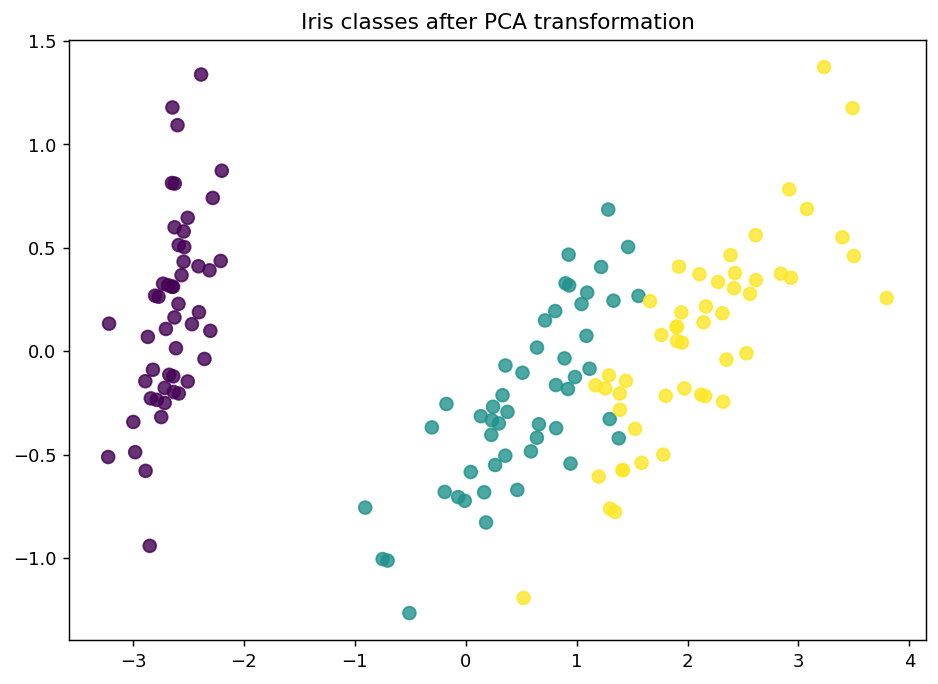

In [30]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [31]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [32]:
X_train.shape

(3, 4)

In [33]:
y_train.shape

(3,)

## Active learning with pool-based sampling

For the classification, we are going to use a simple k-nearest neighbors classifier. In this step, we are also going to initialize the ```ActiveLearner```.

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

"To create an ActiveLearner object, you need to provide two things: a scikit-learn estimator object and a query strategy function (The latter one is optional, the default strategy is maximum uncertainty sampling.). Regarding the query strategies, you can find built-ins in modAL.uncertainty, but you can also implement your own. For instance, you can just simply do the following.

    from modAL.models import ActiveLearner
    from modAL.uncertainty import uncertainty_sampling
    from sklearn.ensemble import RandomForestClassifier

    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        query_strategy=uncertainty_sampling
    )

In modAL, currently there are three built-in query strategies: max uncertainty, max margin and max entropy(...)"

[https://github.com/modAL-python/modAL/blob/99d4947f69f0b2247f9916a6ef44463f7af06c55/docs/source/content/models/ActiveLearner.rst]

Let's see how our classifier performs on the initial training set!

In [35]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

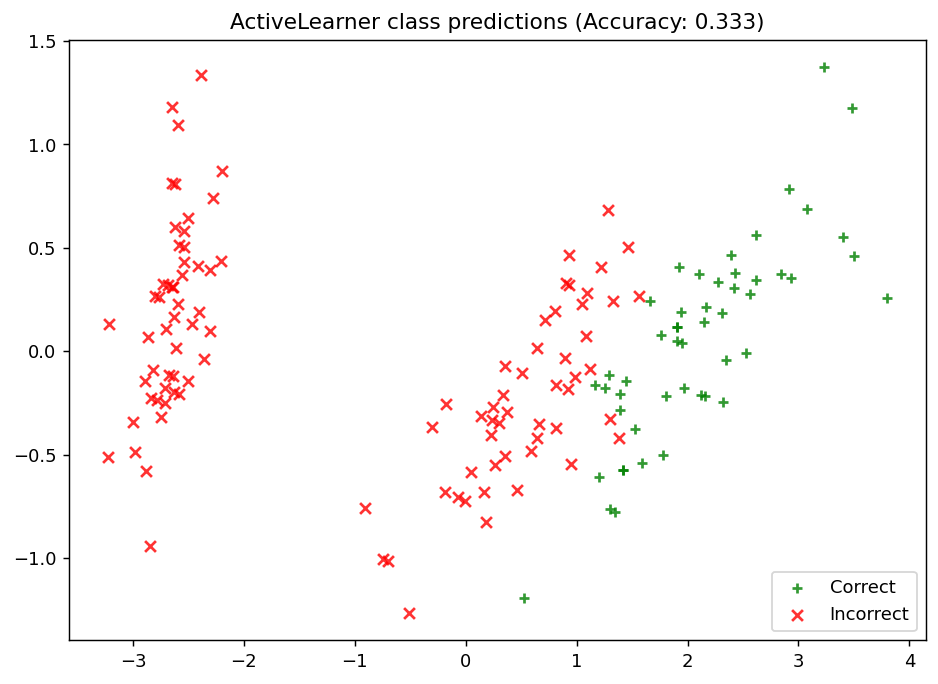

In [36]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

## Update our model by pool-based sampling our "unlabeled" dataset $\mathcal{U}$

As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn't seen before. Using uncertainty sampling, our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures — see the documentation for more on specific [classification uncertainty measures](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Uncertainty-sampling.html). With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [37]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y)

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw) # 148141: Score na wszystkich danych
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  print("X_raw type: ", type(X_raw))
  print("X_raw shape: ", X_raw.shape)
  print("y_raw shape: ", y_raw.shape)


  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (146, 4)
y_pool shape:  (146,)
Accuracy after query 1: 0.6667
X_raw type:  <class 'numpy.ndarray'>
X_raw shape:  (150, 4)
y_raw shape:  (150,)
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (145, 4)
y_pool shape:  (145,)
Accuracy after query 2: 0.6667
X_raw type:  <class 'numpy.ndarray'>
X_raw shape:  (150, 4)
y_raw shape:  (150,)
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (144, 

## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

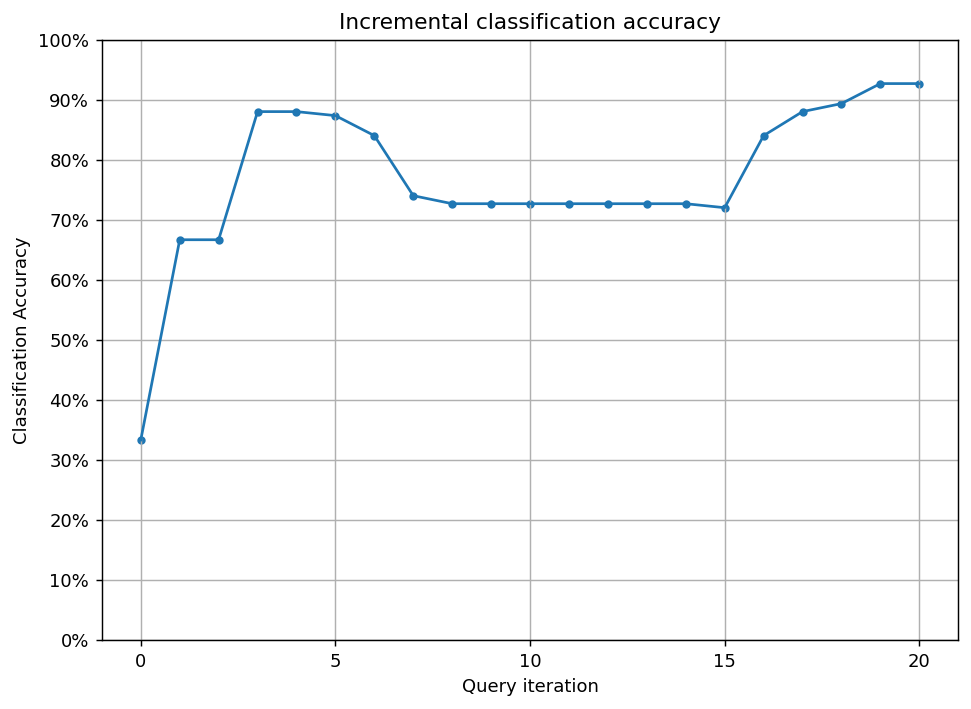

In [38]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

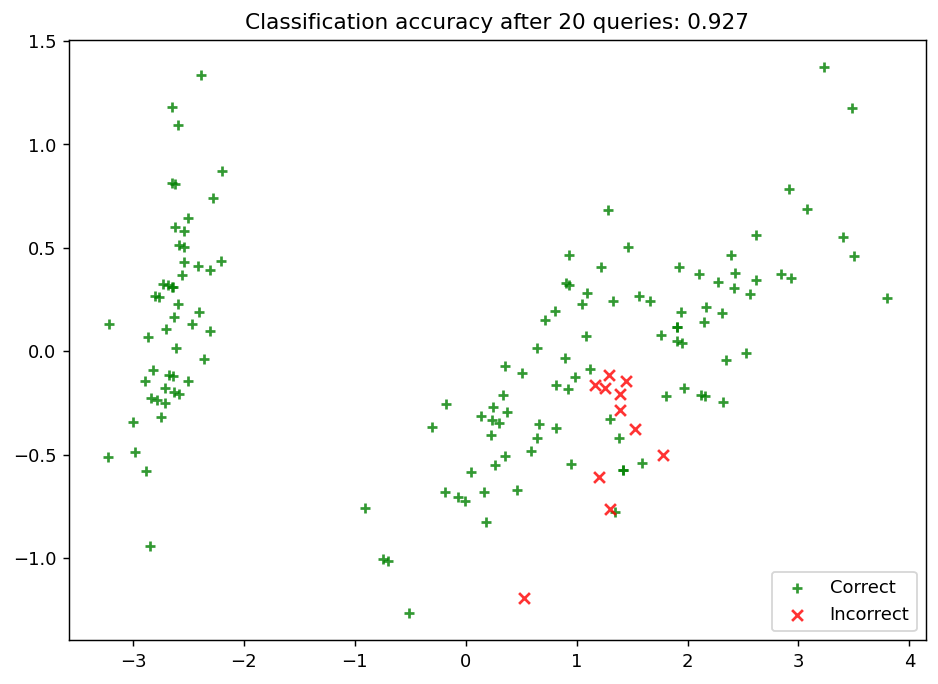

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: Proper evaluation: on the pool excluding the teaching pool (Please comment on the differences)

#148141: teching pool to taki który na którym już się uczyliśmy

In [40]:
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [41]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train type:  <class 'numpy.ndarray'>
X_train shape:  (3, 4)
y_train shape:  (3,)


In [42]:
import copy

In [43]:
X_pool = copy.deepcopy(X_raw)
y_pool = copy.deepcopy(y_raw)

In [44]:
#unqueried_score = learner.score(X_raw, y_raw)
unqueried_score = learner.score(X_pool, y_pool)

In [45]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, ) # 148141: Nowa porcja danych
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y) # 148141: trenowanie klasyfikatora, jak mamy już nowe dane

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)


  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_pool, y_pool) # 148141: predykcja i pomiar acc na jeszcze nie widzianych danych
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)


X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (149, 4)
y_pool shape:  (149,)
Accuracy after query 1: 0.6644
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (148, 4)
y_pool shape:  (148,)
Accuracy after query 2: 0.6622
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (147, 4)
y_pool shape:  (147,)
Accuracy after query 3: 0.8776
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.n

## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

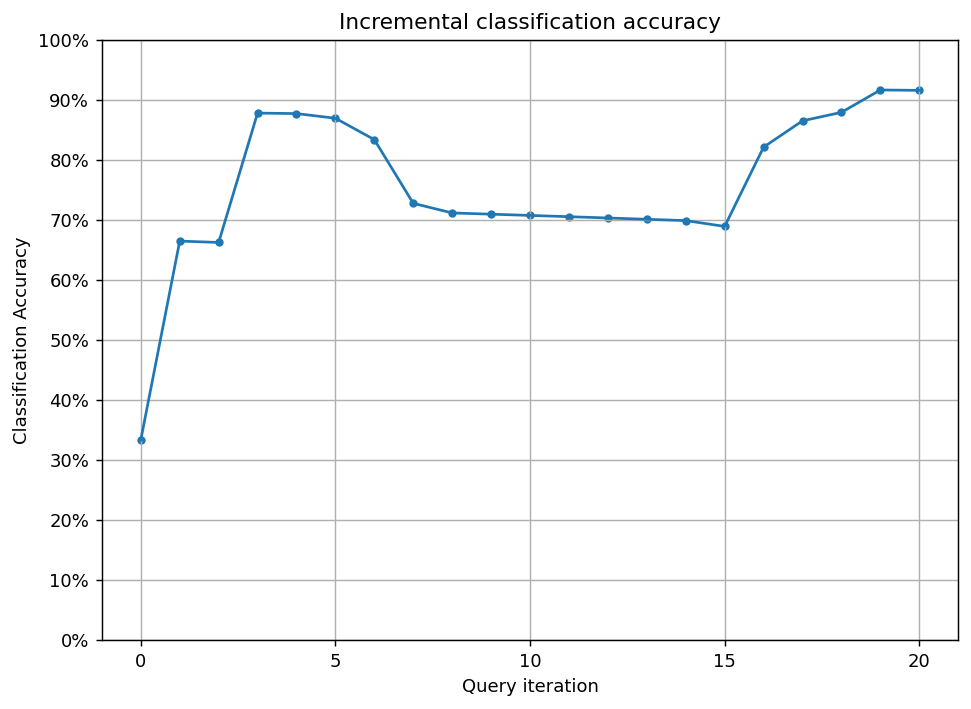

In [46]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

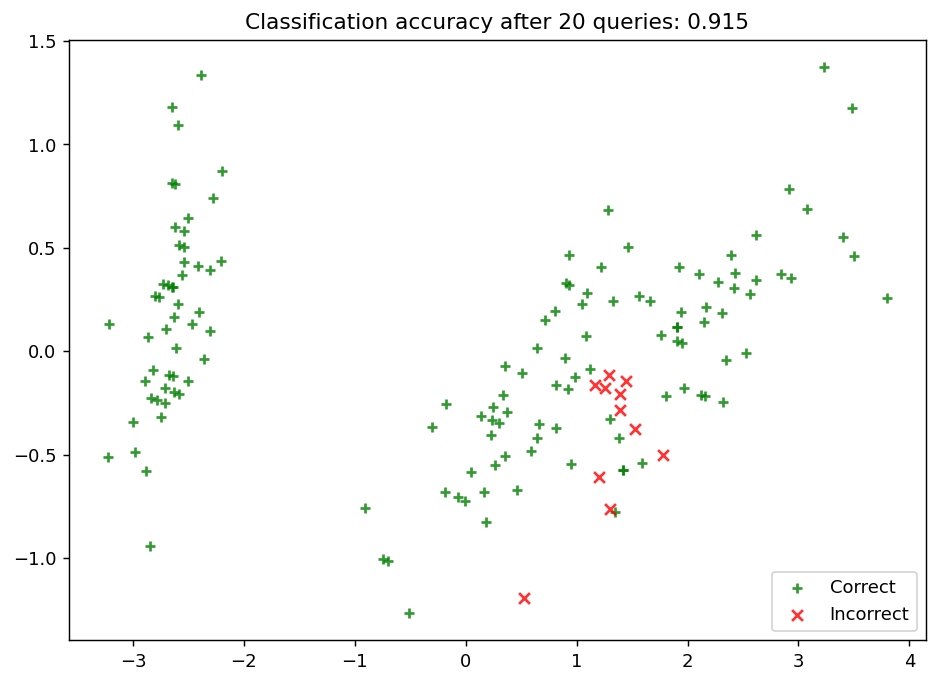

In [47]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: Even more proper evaluation: on the pool excluding the teaching pool with prior raw data shuffling (Please comment on the differences)

In [48]:
np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [49]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [50]:
np.random.shuffle(not_yet_shuffling_indices)

In [51]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

array([ 31,  67, 122, 119, 138, 117,  82,  65,  16,  37, 147,  32,   8,
       112,  20, 114,  29,  10, 120, 100,  51, 131, 116,  42,  24,  49,
        72,  74, 110, 144,  30,   6,  25,  14,  27,  95, 143,  81,  79,
        18,  19,  34,  33,  99,  57,  90,  61,   9,   0,  55,  40, 102,
       123, 133, 111,  21,  83,  43, 128,  56, 129,  85, 126,  58, 103,
         4,  35,  50,  48, 124,  97,  28, 137,  17, 121,  89,  77,  23,
       101,  59,   3,  60,  75,  41, 113,  93,  71,   5,  38, 140,  47,
        98, 141,  22,  68, 134, 108,  80, 146, 106,  62, 105,  46,  84,
       104,  73,  54,  39, 115,  26,  69,  64,  12, 142, 148,  13, 118,
        53,  36, 145, 109,  88,  92,  44, 139,  96,  86,  94,  15, 132,
        78,  87, 136,  45, 135,   1,  52,   7, 127, 125, 107,  11,  63,
        76,  91,  66,   2, 130, 149,  70])

In [52]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [53]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0) # 148141: pool nie zawiera danych treningowych oraz dane są potasowane
y_pool = np.delete(y_raw, training_indices, axis=0)

In [54]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [55]:
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [56]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train type:  <class 'numpy.ndarray'>
X_train shape:  (3, 4)
y_train shape:  (3,)


In [57]:
#N_QUERIES = 20
N_QUERIES = 50
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  print("X type: ", type(X))
  print("X shape: ", X.shape)
  print("y shape: ", y.shape)
  learner.teach(X=X, y=y)

  learner_X_training = learner.X_training
  print("learner_X_training type: ", type(learner_X_training))
  print("learner_X_training shape: ", learner_X_training.shape)
  print("learner_X_training shape: ", learner_X_training.shape)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  print("X_pool type: ", type(X_pool))
  print("X_pool shape: ", X_pool.shape)
  print("y_pool shape: ", y_pool.shape)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_pool, y_pool)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (146, 4)
y_pool shape:  (146,)
Accuracy after query 1: 0.6575
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (145, 4)
y_pool shape:  (145,)
Accuracy after query 2: 0.6552
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (144, 4)
y_pool shape:  (144,)
Accuracy after query 3: 0.6528
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.n

## Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

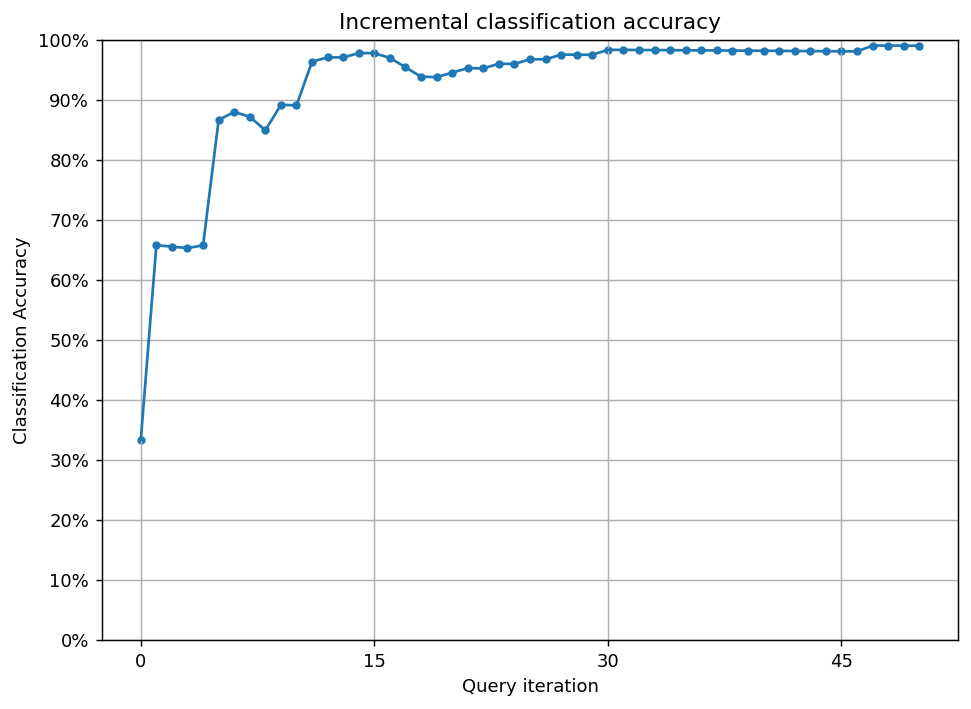

In [58]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

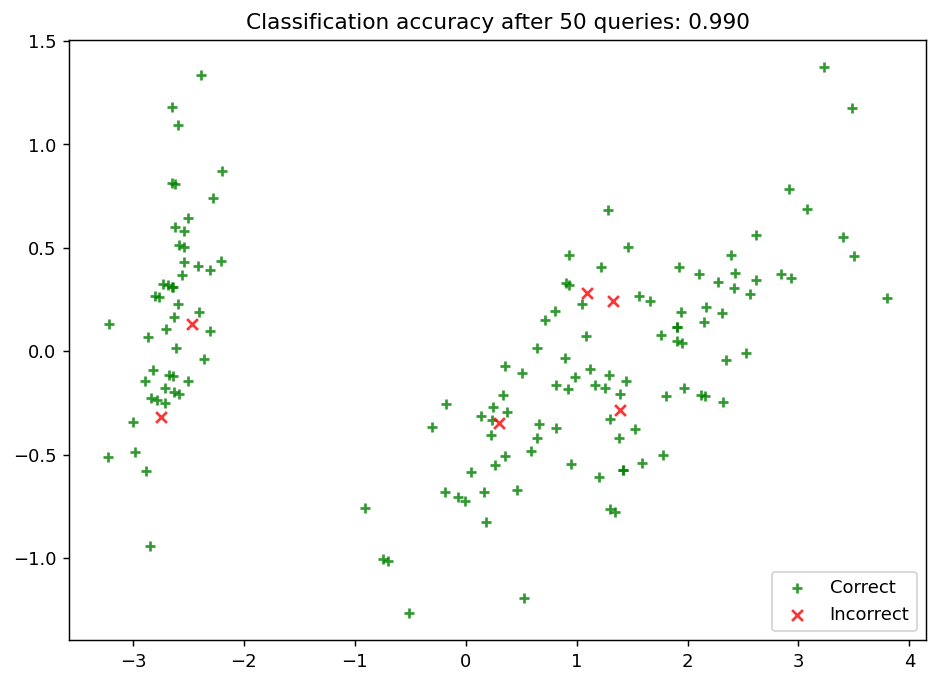

In [59]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

Uncertainty sampling
==================

When you present unlabelled examples to an active learner, it finds you the most *useful* example and presents it for you to be labelled. This is done by first calculating the *usefulness* of prediction (whatever it means) for each example and select an instance based on the usefulness. The thing is, there are several ways to measure this. They are based upon the classification uncertainty, hence they are called *uncertainty measures*. In modAL, currently you can select from three built-in measures: *classification uncertainty*, *classification margin* and *classification entropy*. In this quick tutorial, we are going to review them. For more details, see Section 2.3 of the awesome book [Active learning by Burr Settles](http://active-learning.net/)!

In [60]:
import numpy as np

Classification uncertainty
-------------------------------------

The simplest measure is the uncertainty of classification defined by

$$U(x)=1-P(\hat{x}|x)$$

where $x$ is the instance to be predicted and $\hat{x}$ is the most likely prediction.

For example, if you have classes ``[0, 1, 2]`` and classification probabilities ``[0.1, 0.2, 0.7]``, the most likely class according to the classifier is ``2`` with uncertainty 0.3. If you have three instances with class probabilities

In [61]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding uncertainties are:

In [62]:
1 - proba.max(axis=1)

array([0.15, 0.4 , 0.39])

In the above example, the most uncertain sample is the second one. When
querying for labels based on this measure, the strategy selects the
sample with the highest uncertainty.

For this ternary classification problem, given the first two
probabilities, the classification uncertainty looks like the following.

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
n_res = 100
p1, p2 = np.meshgrid(np.linspace(0, 1, n_res), np.linspace(0, 1, n_res))
p3 = np.maximum(1 - p1 - p2, 0)

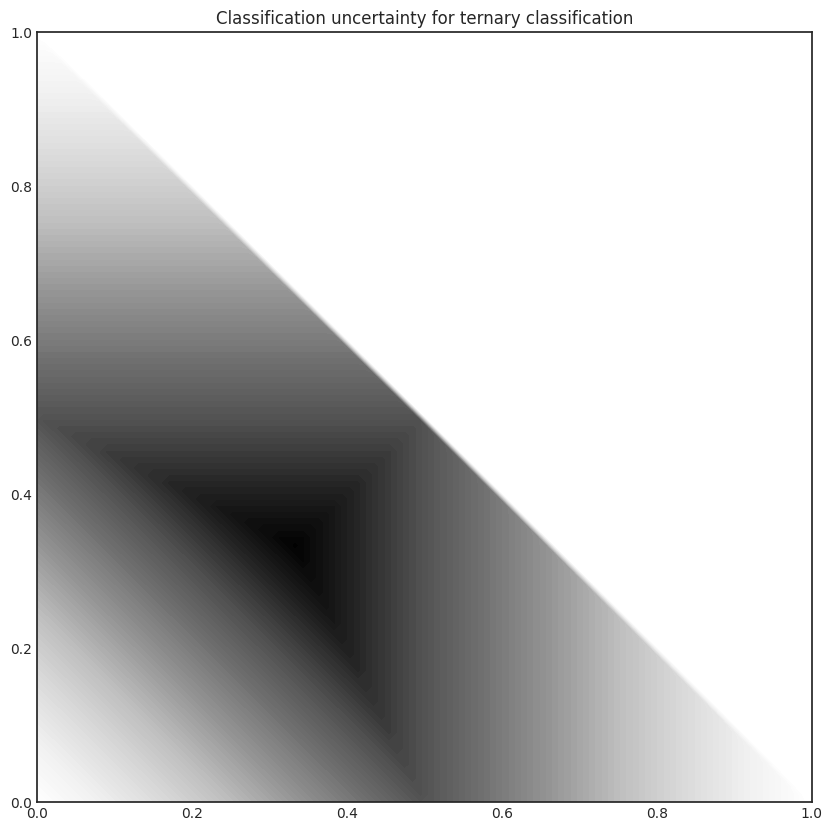

In [64]:
uncertainty = 1 - np.maximum.reduce([p1, p2, p3])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, uncertainty*((p1+p2) < 1), 100)
    plt.title('Classification uncertainty for ternary classification')

## Szwabe: What about a 2-class case? (Please comment on the differences)

In [65]:
p1.shape

(100, 100)

In [66]:
for p1_slice_idx in range(p1.shape[0]):
  p1_slice = p1[p1_slice_idx, :]


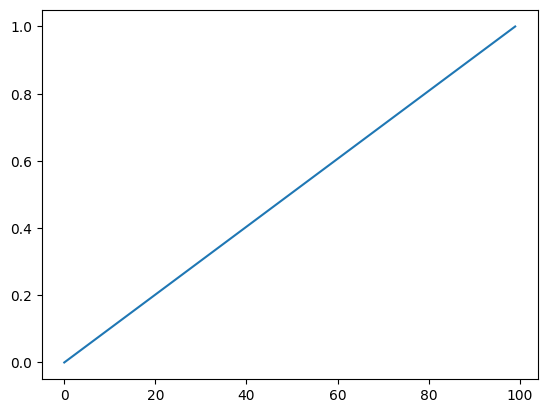

In [67]:
plt.plot(p1_slice)

In [68]:
p2_slice = 1 - p1_slice

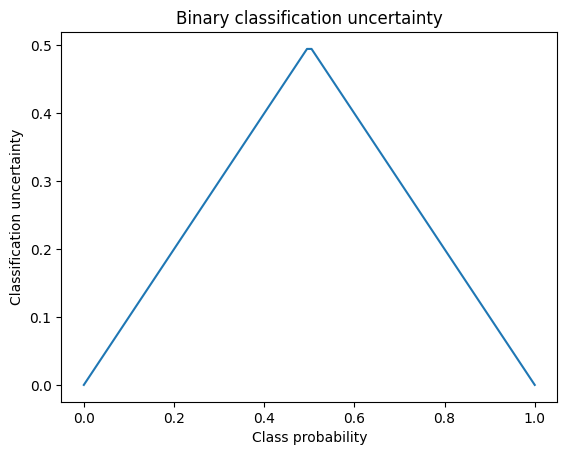

In [69]:
uncertainty_slice = 1 - np.maximum.reduce([p1_slice, p2_slice])
plt.plot(p1_slice, uncertainty_slice)
plt.title('Binary classification uncertainty')
plt.xlabel('Class probability')
plt.ylabel('Classification uncertainty')
plt.show()

In [ ]:
p1[-1, :] == p1_slice

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
p1[-1, :] == p1[-2, :]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
uncertainty.shape

(100, 100)

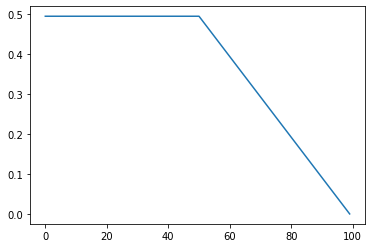

In [ ]:
plt.plot(uncertainty[:,50])
plt.show()

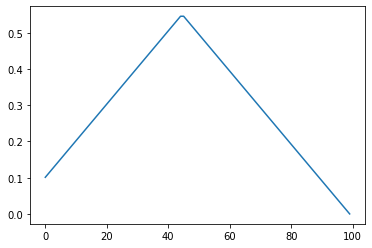

In [ ]:
plt.plot(uncertainty[:,10])
plt.show()

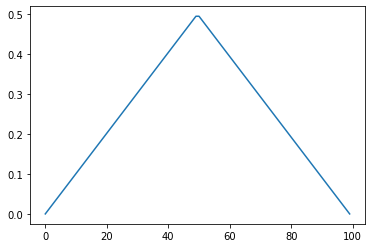

In [ ]:
plt.plot(uncertainty[:,0])
plt.show()

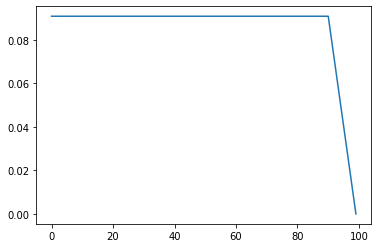

In [ ]:
plt.plot(uncertainty[:,90])
plt.show()

Classification margin
-------------------------------

Classification margin is the difference in probability of the first and second most likely prediction, that is, it is defined by

$$M(x)=P(\hat{x_1}|x)-P(\hat{x_2}|x)$$

where $\hat{x_1}$ and $\hat{x_2}$ are the first and second most likely classes. Using the same example we used for classification uncertainty, if the class probabilities are

In [ ]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding margins are:

In [ ]:
part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

In [ ]:
margin

array([0.75, 0.3 , 0.22])

When querying for labels, the strategy selects the sample with the *smallest* margin, since the smaller the decision margin is, the more unsure the decision. In this case, it would be the third sample. For this ternary classification problem, the classifier margin plotted against the first two probabilities are the following.

In [ ]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T

part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

margin = margin.reshape(p1.shape)

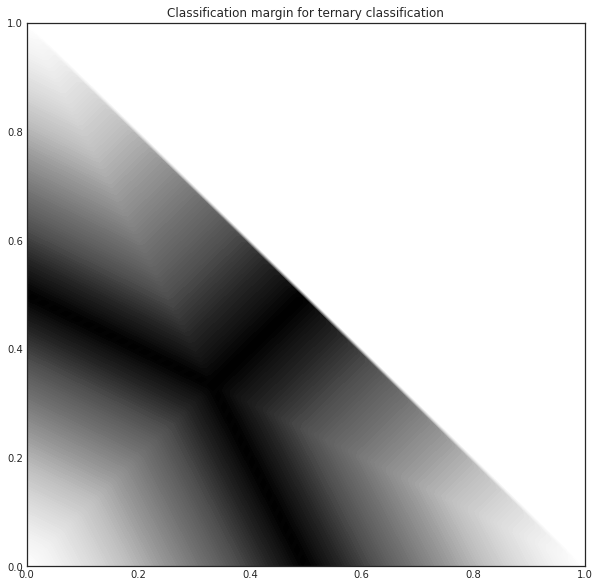

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, (1-margin)*((p1+p2) < 1), 100)
    plt.title('Classification margin for ternary classification')

## Szwabe: What about a 2-class case? (Please comment on the differences)

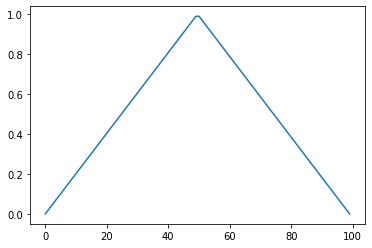

In [ ]:
plt.plot((1-margin)[:,0])
plt.show()

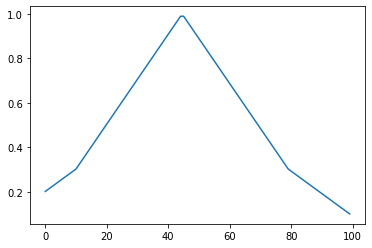

In [ ]:
plt.plot((1-margin)[:,10])
plt.show()

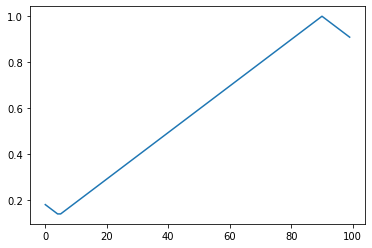

In [ ]:
plt.plot((1-margin)[:,90])
plt.show()

Classification entropy
--------------------------------

The third built-in uncertainty measure is the classification entropy, which is defined by

$$H(x)=-\sum_{k}p_k\log(p_k)$$

where $p_k$ is the probability of the sample belonging to the $k$-th class. Heuristically, the entropy is proportional to the average number of guesses one has to make to find the true class. In our usual example

In [ ]:
proba = np.array([[0.1 , 0.85, 0.05],
                  [0.6 , 0.3 , 0.1 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding entropies are

In [ ]:
from scipy.stats import entropy

entropy(proba.T)

array([0.51818621, 0.89794572, 0.66874809])

The closer the distribution to uniform, the larger the entropy. Again, if we plot the entropy against the first two probabilities of a ternary classification problem, we obtain the following.

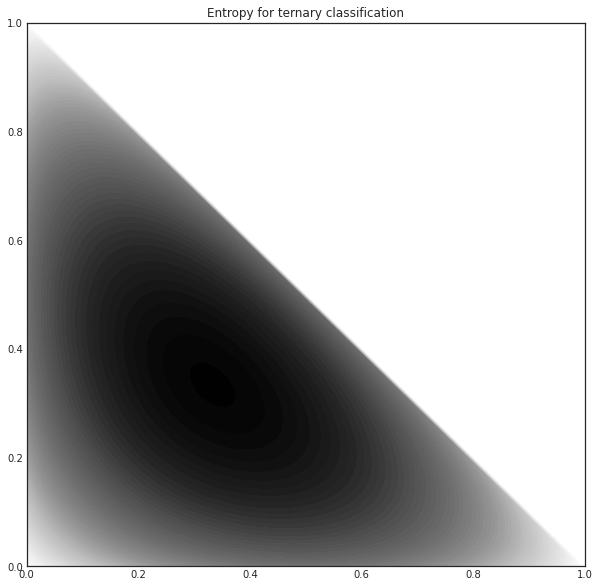

In [ ]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T
entr = entropy(proba.T).reshape(p1.shape)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, entr*((p1+p2) < 1), 100)
    plt.title('Entropy for ternary classification')

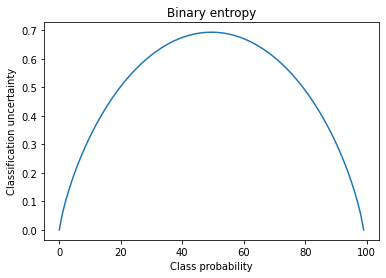

In [ ]:
plt.plot(entr[:,0])
plt.title('Binary entropy')
plt.xlabel('Class probability')
plt.ylabel('Classification uncertainty')
plt.show()

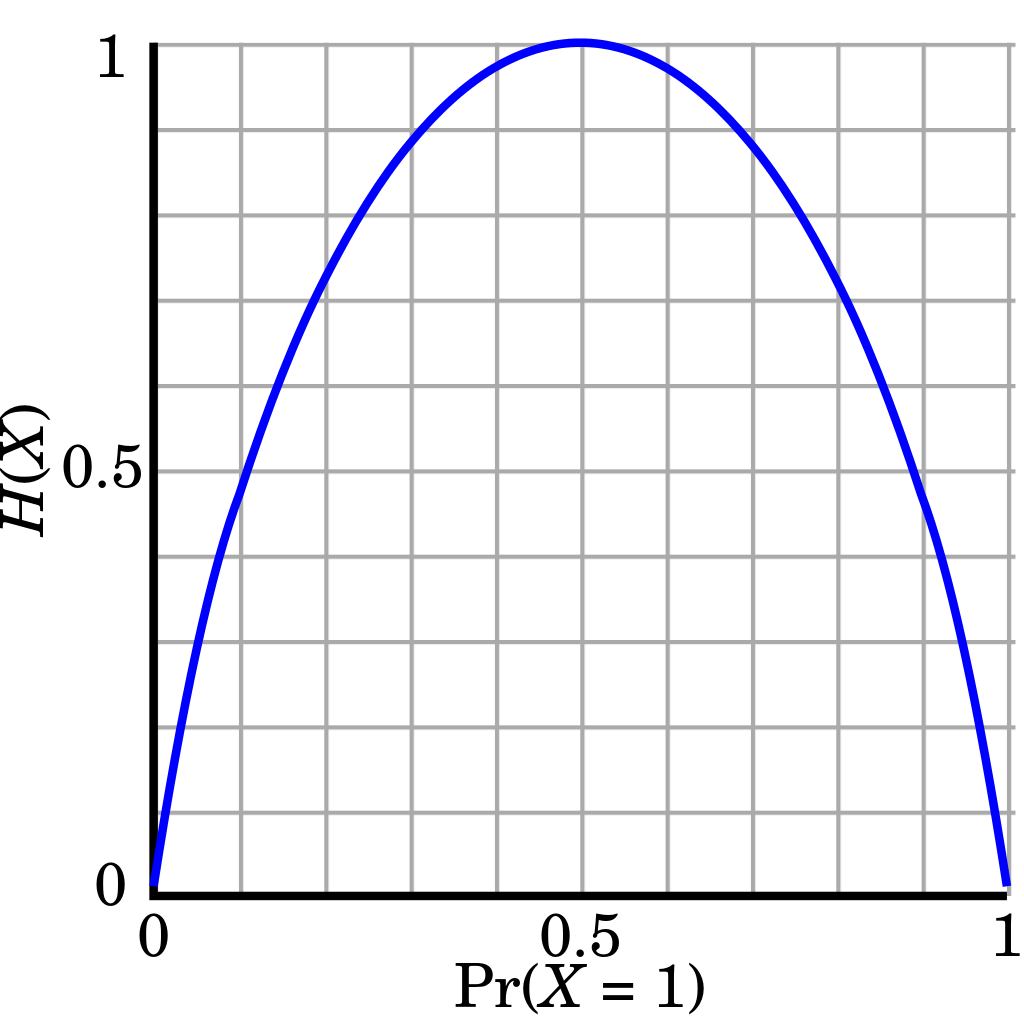

Entropy of a Bernoulli trial as a function of binary outcome probability, called the binary entropy function.

[https://en.wikipedia.org/wiki/Binary_entropy_function]

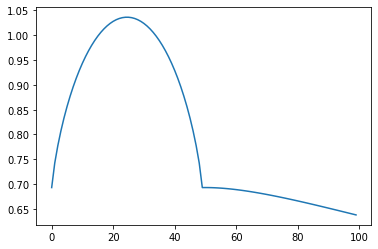

In [ ]:
plt.plot(entr[:,50])
plt.show()

## Szwabe: What about a 2-class case? (Please comment on the differences)

Query by committee
=================

*Query by committee* is another popular active learning strategy, which alleviates many disadvantages of uncertainty sampling. For instance, uncertainty sampling tends to be biased towards the actual learner and it may miss important examples which are not in the sight of the estimator. This is fixed by keeping several hypotheses at the same time, selecting queries where disagreement occurs between them. In this example, we shall see how this works in the simplest case, using the iris dataset.

The executable script for this example is [available here](https://github.com/cosmic-cortex/modAL/blob/master/examples/query_by_committee.py)!

To enforce a reproducible result across runs, we set a random seed.

In [ ]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

The dataset
-----------------

We are going to use the iris dataset for this example. For more information on the iris dataset, see [its wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set). For its scikit-learn interface, see [the scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html).

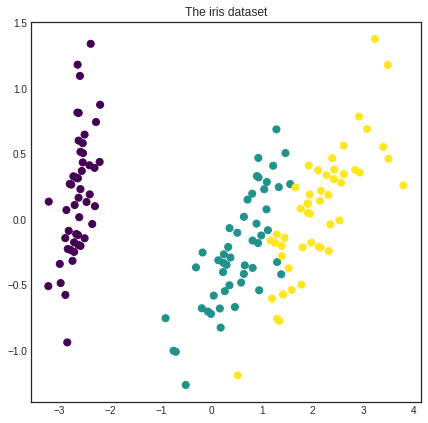

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# loading the iris dataset
iris = load_iris()

# visualizing the classes
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()


In [ ]:
print(iris["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Initializing the Committee
--------------------------

In this example, we are going to use the ``Committee`` class from ``modAL.models``. Its interface is almost exactly identical to the
``ActiveLearner``. Upon initialization, ``Committee`` requires a list of active learners. First, we generate the pool of unlabeled data.

In [ ]:
from copy import deepcopy

# generate the pool
X_pool = deepcopy(iris['data'])
y_pool = deepcopy(iris['target'])

Now we are ready to initialize the ```Committee```. For this, we need a list of ```ActiveLearner``` objects, which we will define now.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner, Committee

# initializing Committee members
n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

As you can see, the various hypotheses (which are taking the form of ActiveLearners) can be quite different.

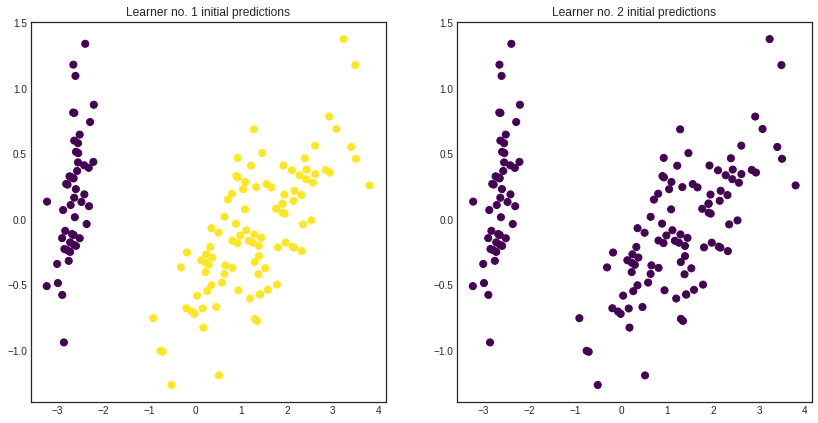

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

Prediction is done by averaging the class probabilities for each learner and chosing the most likely class.

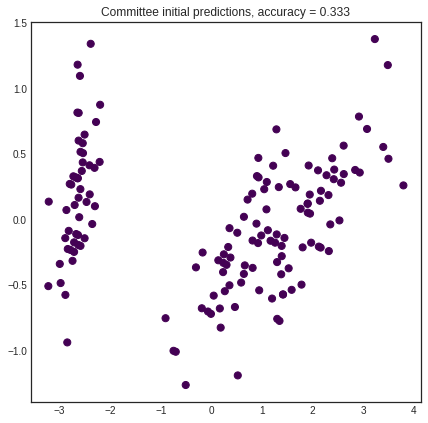

In [ ]:
unqueried_score = committee.score(iris['data'], iris['target'])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

Active learning
----------------------

The active learning loop is the same as for the ``ActiveLearner``.

In [ ]:
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(iris['data'], iris['target']))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

After a few queries, the hypotheses straighten out their disagreements and they reach consensus. Prediction accuracy is greatly improved in this case.

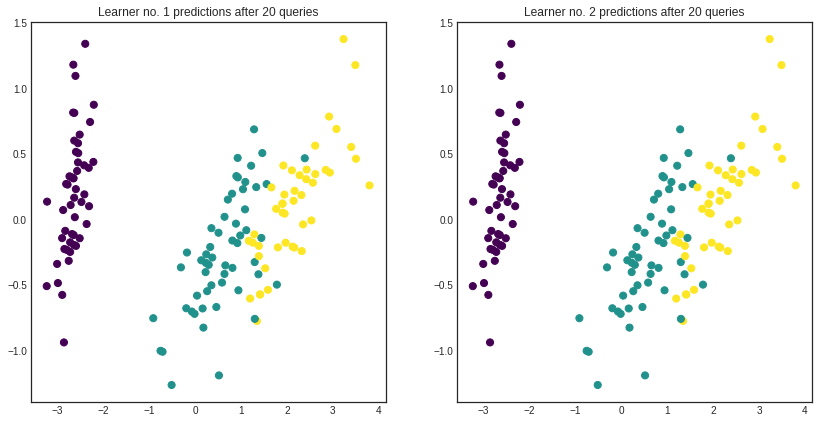

In [ ]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

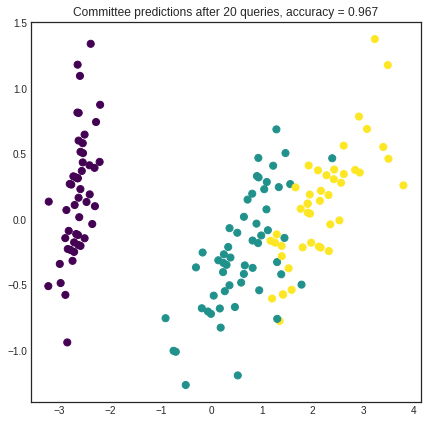

In [ ]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(iris['data'], iris['target'])))
    plt.show()

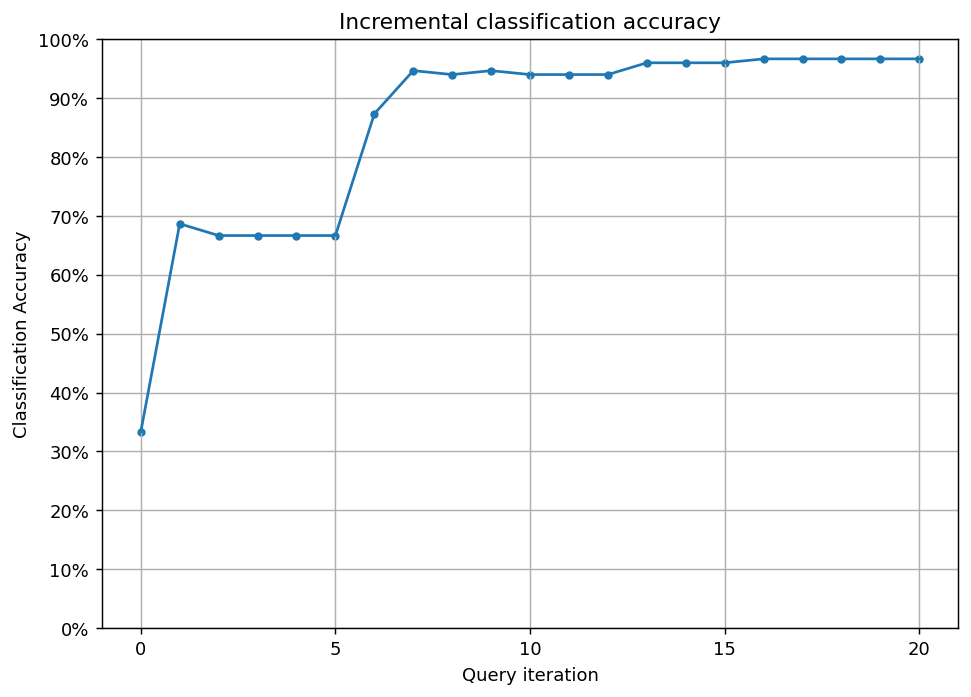

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Szwabe: What about a 2-class case? (Please comment on the differences)
# 148141: Dla dwóch klas wszystkie metody są identyczne i wybiorą punkt najbliżej środka

#Comparison of query strategies

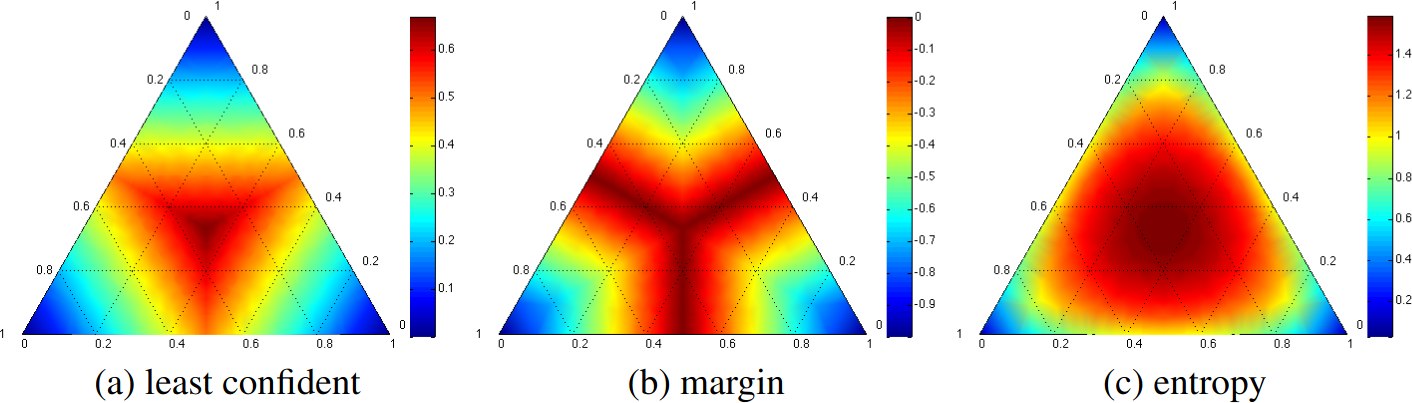

Heatmaps illustrating the query behavior of the common query strategies (aka uncertainty measures) in a three-label classification problem.
Corners indicate cases/samples where one label has very high probability, with the opposite edge showing the probability range for the other two classes when that label has very low probability.
The most informative query region for each strategy is shown in dark red, radiating from the centers. [Settles, Burr. "Active learning literature survey." (2009), https://minds.wisconsin.edu/bitstream/handle/1793/60660/TR1648.pdf]

In [ ]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

In [ ]:
#query_strategy=uncertainty_sampling

In [ ]:
np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [ ]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)

In [ ]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

array([ 62,  33, 107,  80,  53,   5,  93,   8, 138,  19,  92,  50,  70,
       126,  91, 101, 128,  35,  44,  99, 117,   9,  15,   4,  58,  10,
        20,  78, 127, 125,  75, 149,  22, 121, 148,  11,  42,  69, 131,
       109, 144,  51, 123,  28, 132, 140,  63, 135,  13, 113, 133, 136,
        97,  49,  26,  57,  38,  81,  34,  46,  29,  94,  60,  12,  72,
       115,  54,  56,  65, 106,  98,  21,  59, 137, 119, 139, 122, 114,
       105,  41,  25,  86,  71,  30,  95, 120,  31,  82, 143,  68,  14,
        73, 103,  66,  90,  85,   2, 108,  24, 145,  32,  79, 129,   0,
         1,  27, 124,  89, 112, 102,  96,  87, 130,  74,  17,   7,  48,
       110,  77, 118,  47,   3,  37, 116,  23, 104,  39, 141,  36,  40,
        43,  76, 100,  83,  64,  84,  45,  88, 142,   6,  16, 147,  55,
        61, 146, 111, 134,  52,  67,  18])

In [ ]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [ ]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train type:  <class 'numpy.ndarray'>
X_train shape:  (3, 4)
y_train shape:  (3,)


In [ ]:
query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling]
query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling"]

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

performance_histories = []

for query_strategy in query_strategies:

  #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
  training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

  X_train = X_raw[training_indices]
  y_train = y_raw[training_indices]

  # Isolate the non-training examples we'll be querying.
  X_pool = np.delete(X_raw, training_indices, axis=0)
  y_pool = np.delete(y_raw, training_indices, axis=0)

  knn = KNeighborsClassifier(n_neighbors=3)
  learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy) # 148141: wybór strategi próbkowania

  N_QUERIES = 20
  #N_QUERIES = 50
  unqueried_score = learner.score(X_pool, y_pool)
  performance_history = [unqueried_score]

  # Allow our model to query our unlabeled dataset for the most
  # informative points according to our query strategy (uncertainty sampling).
  for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    print("X type: ", type(X))
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    learner.teach(X=X, y=y)

    learner_X_training = learner.X_training
    print("learner_X_training type: ", type(learner_X_training))
    print("learner_X_training shape: ", learner_X_training.shape)
    print("learner_X_training shape: ", learner_X_training.shape)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
    print("X_pool type: ", type(X_pool))
    print("X_pool shape: ", X_pool.shape)
    print("y_pool shape: ", y_pool.shape)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_pool, y_pool)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
  performance_histories.append(performance_history)

X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (146, 4)
y_pool shape:  (146,)
Accuracy after query 1: 0.3288
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (145, 4)
y_pool shape:  (145,)
Accuracy after query 2: 0.6621
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (144, 4)
y_pool shape:  (144,)
Accuracy after query 3: 0.8056
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.n

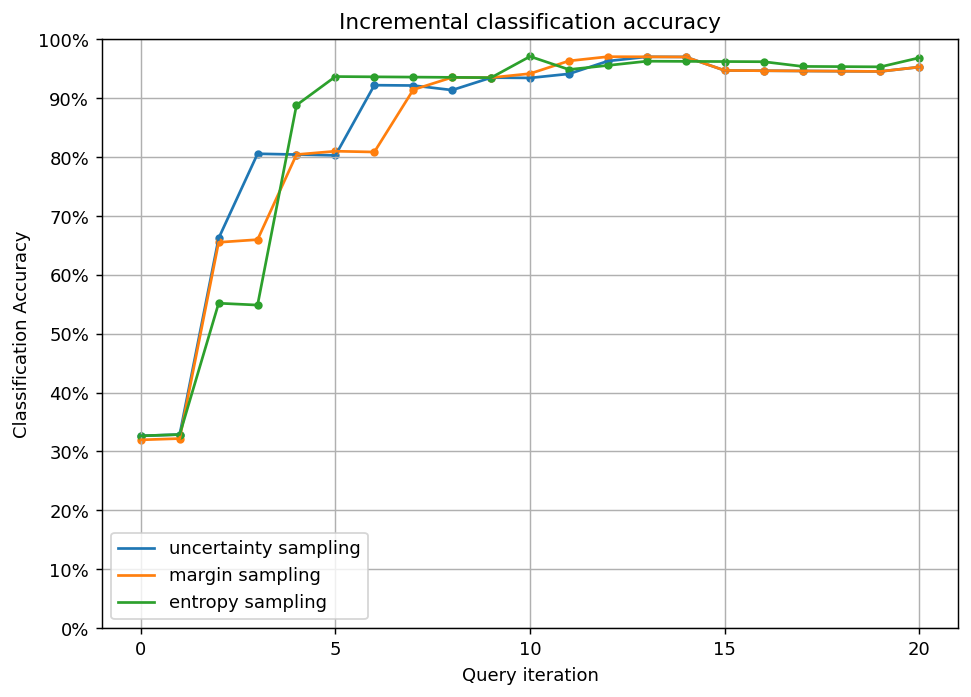

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

for query_strategy_idx, query_strategy in enumerate(query_strategies):
  performance_history = performance_histories[query_strategy_idx]
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  ax.plot(performance_history, label=query_strategy_label)
  ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

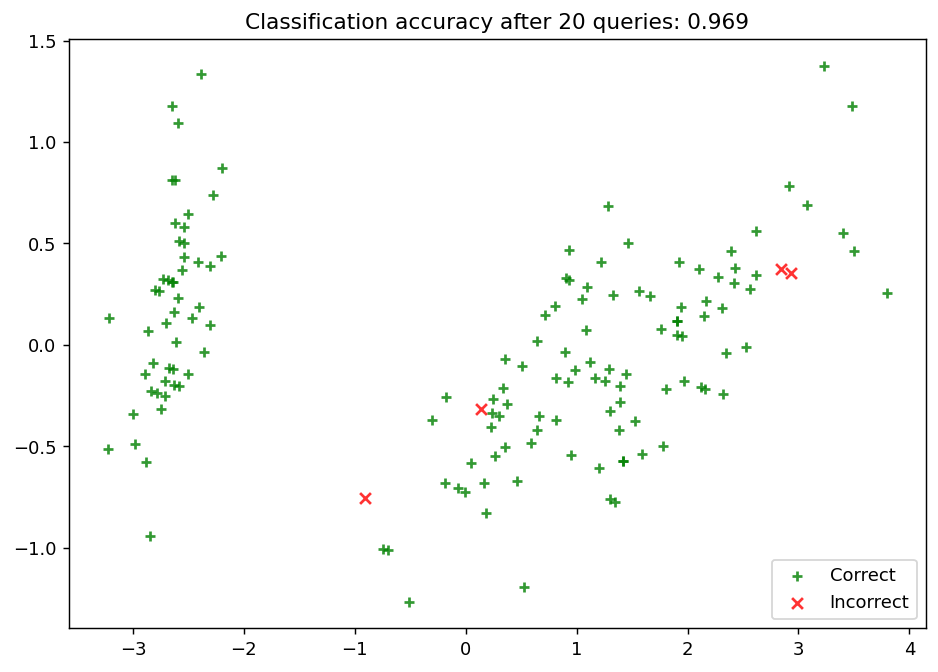

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

#Szwabe: More reliable comparison of query strategies  (Please comment on the differences)

In [ ]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

In [ ]:
#query_strategy=uncertainty_sampling

In [ ]:
#np.random.seed(RANDOM_STATE_SEED)
np.random.seed()

In [ ]:
not_yet_shuffling_indices = np.arange(y_raw.shape[0])
not_yet_shuffling_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [ ]:
np.random.shuffle(not_yet_shuffling_indices)

In [ ]:
shuffling_indices = not_yet_shuffling_indices
shuffling_indices

array([123,  64,  53, 100,   5, 140, 144,  59,  16, 126, 116, 133,  91,
       134,  78, 113,  56,  55,  28, 110,  21, 104,  88, 103,  98,   8,
       139,   7, 114,  14,  67,   4,  57,  54,   2, 148, 111,  23,  52,
       112,  13,  70,   9,  72, 117,  17,  60,  62,  68,  99, 120,  51,
       119, 138,  90, 128,  75,  46, 127, 146,  85,  22,  66,  27, 107,
       124,  40,  33,   0, 108,   3,  20,  39,  97,  48,  36,  12,  38,
        43, 149,  96,  26,  32,  58,  11,  82,  10,  71,  69,  25,  83,
        31,  18,   6,  19,  34, 101, 142,  92,  15,  47, 105, 137,  79,
        74, 135,  77, 115, 132, 125, 109, 130,  65,  50,  49, 147,  61,
        73,  35,  80, 131,  76, 121,  89,  44,  95,  45,  63,  94,  93,
       136, 129, 118,  37, 143, 122,  81,   1,  87, 106, 141, 102,  30,
        41, 145,  84,  29,  42,  24,  86])

In [ ]:
X_raw = X_raw[shuffling_indices]
y_raw = y_raw[shuffling_indices]

In [ ]:
# Isolate our examples for our labeled dataset.
#n_labeled_examples = X_raw.shape[0]

#training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [ ]:
#learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

In [ ]:
print("X_train type: ", type(X_train))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train type:  <class 'numpy.ndarray'>
X_train shape:  (3, 4)
y_train shape:  (3,)


In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [ ]:
from numpy.random.mtrand import random_sample
#query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling]
#query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling"]
query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling, random_sampling]
query_strategy_labels = ["uncertainty sampling", "margin sampling", "entropy sampling", "random sampling"]

In [ ]:
#performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[]}


In [ ]:
performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
number_of_tests = 44

for test_number in range(number_of_tests): # 148141 wiele testów dla każdej strategi

  np.random.shuffle(not_yet_shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    knn = KNeighborsClassifier(n_neighbors=3)
    learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    N_QUERIES = 20
    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      #Szwabe: Could we use (and evaluate) another predictive model for the actual ('on-production') predictions in parallel to the active learner? What properties such a system would have if we did use an additional main predictor and the query strategy was random sampling?
      # 148141: Tak, jak model nie ma predict_proba to można innego użyć do samego wyboru kolejnej próbki

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)




Streaming output truncated to the last 5000 lines.
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (146, 4)
y_pool shape:  (146,)
Accuracy after query 1: 0.3219
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (145, 4)
y_pool shape:  (145,)
Accuracy after query 2: 0.3172
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (144, 4)
y_pool shape:  (144,)
Accuracy after query 3: 0.3125
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y sha

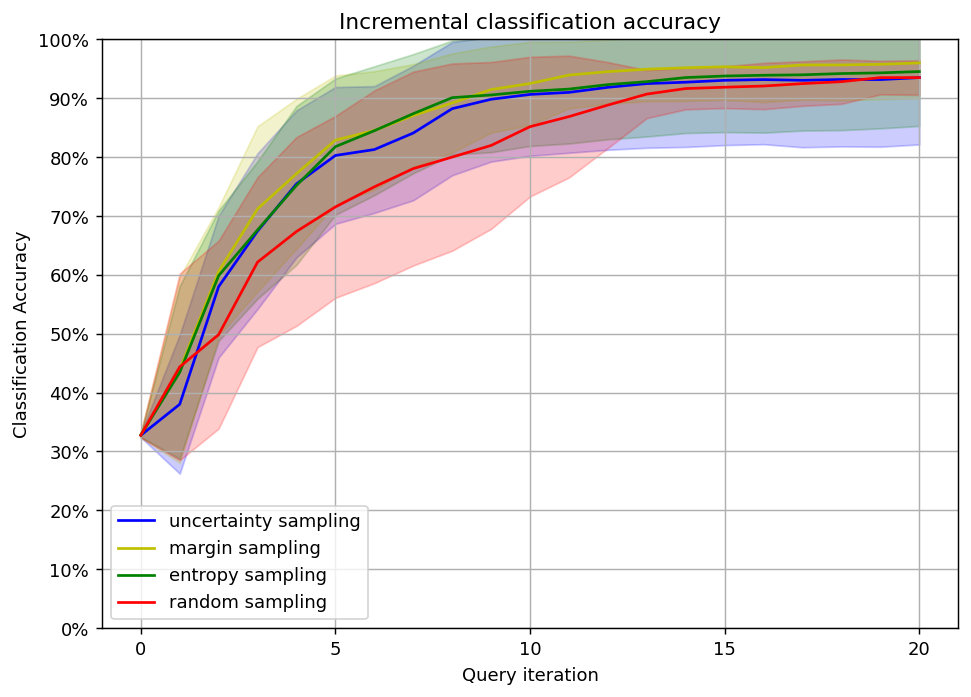

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

#Szwabe: Set an appropriate number of test repetitions in order to compare practical value of the four sampling strategies in the most reliable way that is still feasible considering the amount of available time (of the classwork). Compare and comment on the practical value of the strategies.

In [ ]:
performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
number_of_tests = 667

for test_number in range(number_of_tests):

  np.random.shuffle(not_yet_shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    knn = KNeighborsClassifier(n_neighbors=3)
    learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    N_QUERIES = 20
    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)

Streaming output truncated to the last 5000 lines.
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (4, 4)
learner_X_training shape:  (4, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (146, 4)
y_pool shape:  (146,)
Accuracy after query 1: 0.3288
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (5, 4)
learner_X_training shape:  (5, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (145, 4)
y_pool shape:  (145,)
Accuracy after query 2: 0.3241
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y shape:  (1,)
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (6, 4)
learner_X_training shape:  (6, 4)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (144, 4)
y_pool shape:  (144,)
Accuracy after query 3: 0.3194
X type:  <class 'numpy.ndarray'>
X shape:  (1, 4)
y sha

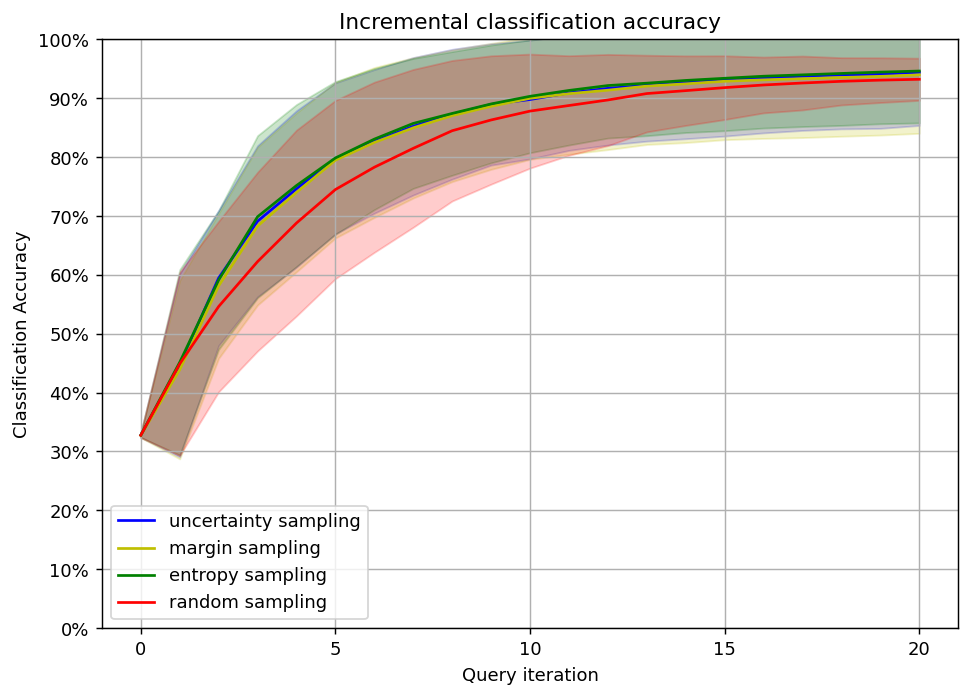

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

# 148141: Losowa strategia jest trochę gorsza, ale szybko dogania resztę strategi w kolejnych iteracjach

In [ ]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==

A working set of packages:

#The cells below are just for your inspiration. If you find them distracting/confusing please delete them ;-)

#Non-simulated user feedback demo

In [ ]:
!pip install modAL

In [ ]:
# import required libraries
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner


## Loading data

We will be using [Optical Recognition of Handwritten Digits Data Set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits). Each sample in this dataset has 64 features coresponding to the color of the pixel in 8x8 grid.

In [ ]:
from sklearn.datasets import load_digits

dataset = load_digits()

print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

After the dataset with `load_digits` function from `sklearn.datasets` module, we need to randomly choose small labeled samples pool. The size of initial labled samples pool can be configured via `N_INITIAL` variable. By default it is equal to 3.

In [ ]:
X_raw = dataset.data
y_raw = dataset.target
normalize_X = lambda x: x / 16
X_raw = normalize_X(X_raw)

N_INITIAL = 3
training_indices = np.random.choice(range(len(X_raw)), size=N_INITIAL, replace=False)
X_train, y_train = X_raw[training_indices], y_raw[training_indices]

X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

X_train, y_train

(array([[0.    , 0.    , 0.3125, 0.75  , 0.5   , 0.    , 0.0625, 0.    ,
         0.    , 0.    , 0.6875, 1.    , 0.3125, 0.8125, 0.375 , 0.    ,
         0.    , 0.    , 0.125 , 0.9375, 1.    , 0.75  , 0.0625, 0.    ,
         0.    , 0.    , 0.    , 0.625 , 1.    , 0.375 , 0.    , 0.    ,
         0.    , 0.    , 0.0625, 0.9375, 1.    , 0.4375, 0.    , 0.    ,
         0.    , 0.    , 0.5   , 1.    , 1.    , 0.6875, 0.    , 0.    ,
         0.    , 0.    , 0.6875, 1.    , 1.    , 0.5625, 0.    , 0.    ,
         0.    , 0.    , 0.375 , 0.75  , 0.75  , 0.1875, 0.    , 0.    ],
        [0.    , 0.    , 0.5625, 0.75  , 0.875 , 0.375 , 0.    , 0.    ,
         0.    , 0.    , 1.    , 0.375 , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.125 , 0.9375, 0.    , 0.    , 0.    , 0.    , 0.    ,
         0.    , 0.5   , 0.9375, 0.75  , 1.    , 0.5625, 0.0625, 0.    ,
         0.    , 0.0625, 0.5   , 0.375 , 0.125 , 0.75  , 0.4375, 0.    ,
         0.    , 0.    , 0.    , 0.    , 0.    , 0

## Random queries score

To check performace of the active learner we will first get the score of our predictions after `N_QUERIES + N_INITIAL` totally random queries. Later we can compare that score with the score we will get when active lerner is used. By default we set `N_QUERIES` to 10.

In [ ]:
from modAL.uncertainty import entropy_sampling
from sklearn.neighbors import KNeighborsClassifier

N_QUERIES = 10

knn = KNeighborsClassifier(n_neighbors=3)
random_label_indices = np.random.choice(range(len(X_pool)), size=N_QUERIES + N_INITIAL, replace=False)
random_label_learner = ActiveLearner(
    estimator=knn,
    query_strategy=entropy_sampling,
    X_training=X_raw[random_label_indices], y_training=y_raw[random_label_indices]
)

random_labels_score = random_label_learner.score(X_raw, y_raw)  #not fully correct from the methodological point of view
random_labels_score

0.38397328881469117

## Active learning setup


Now we will create learner with `N_INITIAL` labeled samples.
We need to choose `estimator` and `query_strategy` parameters for `ActiveLearner` class from the `modAL`. We will teach that learner in the next parts. The initial score of learner is very small (around 0.1).

In [ ]:
from modAL.uncertainty import entropy_sampling
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
# initializing the active learner
learner = ActiveLearner(
    estimator=knn,
    query_strategy=entropy_sampling,
    X_training=X_train, y_training=y_train
)

unqueried_score = learner.score(X_raw, y_raw) #not fully correct from the methodological point of view
unqueried_score

0.10127991096271564

## Oracle - User UI (Google spreadsheet)
Now with our learner in place we want to setup an environment for the user to interact with learner (so that user can label samples learner queries for). For that purpose we will use the simples UI framework there is: Google spreadsheet.
To create and interact with an spreadsheet you will first need to authenticate via your Google Account (run script below). Then go to https://sheets.google.com. You should see a newly created spreadsheet called "Oracle UI". We will be using it as a bridge between the user (oracle) and active learner. Active learner will descide which unlabled sample should be labeled next and push it to the spreadsheet. The oracle then should make the decision what is a digit that learner queries for.

This process will repeat `N_QUERIES` times. After each iteration current score of active learner will be displayed.

In [ ]:
!pip install gspread-formatting

In [ ]:
# authenticate
from google.colab import auth
auth.authenticate_user()

#import gspread
from gspread_formatting import batch_updater, cellFormat, format_cell_range
#from oauth2client.client import GoogleCredentials
#gc = gspread.authorize(GoogleCredentials.get_application_default())


import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)


# create new spreadsheet
spreadsheet_name = 'Oracle UI'

try:
  sh = gc.open(spreadsheet_name)
except gspread.SpreadsheetNotFound:
  sh = gc.create(spreadsheet_name)
# open the new sheet and add some data.
# this is done just to test Google spreadsheet intergration
worksheet = sh.sheet1
worksheet.clear()
worksheet.update('A1', 'Oracle UI')

batch = batch_updater(sh)
#batch.set_row_height(worksheet, '6:12', 50)
batch.set_row_height(worksheet, '6:13', 50)
batch.set_column_width(worksheet, 'B:I', 50)
batch.execute()

label_input_cell = 'A3'
feedback_cell = 'A4'

input_border_style = {
  'style': 'SOLID_THICK',
  'color': {
    'blue': 0.0,
    'red': 1.0,
    'green': 0.0
  }
}
label_input_cell_format = cellFormat(borders={'top': input_border_style, 'bottom': input_border_style, 'left': input_border_style, 'right': input_border_style })
format_cell_range(worksheet, label_input_cell, label_input_cell_format)

# Go to https://sheets.google.com to see your new spreadsheet.


{'replies': [{}],
 'spreadsheetId': '1B-WIHJFv_x8wEtRZOy9v6LTo3v7uhawU_gfhPv8Zjz8'}

In [ ]:
# create new spreadsheet
spreadsheet_name = 'Oracle UI'

try:
  sh = gc.open(spreadsheet_name)
except gspread.SpreadsheetNotFound:
  sh = gc.create(spreadsheet_name)
# open the new sheet and add some data.
# this is done just to test Google spreadsheet intergration
worksheet = sh.sheet1
worksheet.clear()
worksheet.update('A1', 'Oracle UI')

batch = batch_updater(sh)
#batch.set_row_height(worksheet, '6:12', 50)
batch.set_row_height(worksheet, '6:13', 50)
batch.set_column_width(worksheet, 'B:I', 50)
batch.execute()

label_input_cell = 'A3'
feedback_cell = 'A4'

input_border_style = {
  'style': 'SOLID_THICK',
  'color': {
    'blue': 0.0,
    'red': 1.0,
    'green': 0.0
  }
}
label_input_cell_format = cellFormat(borders={'top': input_border_style, 'bottom': input_border_style, 'left': input_border_style, 'right': input_border_style })
format_cell_range(worksheet, label_input_cell, label_input_cell_format)

# Go to https://sheets.google.com to see your new spreadsheet.

{'replies': [{}],
 'spreadsheetId': '1B-WIHJFv_x8wEtRZOy9v6LTo3v7uhawU_gfhPv8Zjz8'}

We also need to delcare helper functions that we will use in active learning loop.
- `get_answer(value)` validates user input from the spreadsheet. It returns `None` if input is invalid or integer from 0 to 9 if input is valid,
- `display_digit(values)` takes 64 features of the digit and updates 64 cells' background colors in the spreadsheet to match those features,

In [ ]:
from gspread_formatting import cellFormat, color

# Parse value from spreadsheet to digit
def parse_answer(value):
  if len(value) != 1:
    return None
  try:
    return int(value)
  except ValueError:
    return None

# Read the value from `label_input_cell` and pares it.
# It runs in loop till `label_input_cell` has a valid value.
def get_answer():
  y = None
  while(y == None):
    value = worksheet.acell(label_input_cell).value
    answer = parse_answer(value)
    if answer == None:
      worksheet.update(feedback_cell, 'Please answer with digit (0-9)')
      sleep(1)
    else:
      y = [answer]
  return y

def get_cell_format(value):
  return cellFormat(
    backgroundColor=color(value, value, value)
  )

def color_cell(cell, value, batch):
  batch.format_cell_range(worksheet, cell, get_cell_format(value))

def display_digit(values):
  batch = batch_updater(sh)

  flat_values = values.flatten()
  value_index = 0

  ascii_capital_b_code = 66
  for row in range(6, 14):
    for col_code in range(ascii_capital_b_code, ascii_capital_b_code + 8):
      col = chr(col_code)
      color_cell(f'{col}{row}', flat_values[value_index], batch)
      value_index += 1

  batch.execute()



## Active learning result

Now we are ready to start active learning. Open 'Oracle UI' spreadsheet in other browser tab and run code script below. You should see that spreadsheet displayes digit that we you need to label. Place your answer in 'A4' cell and submit change (blur 'A4' cell). Displayed digit should update.
After `N_QUERIES` queries active learning loop will end. Accuracy history of learner should be displayed to the screen (it is also storied in the `performance_history` variable).

Feel free to run the below script multiple times to increase model's accuracy.

In [ ]:
from time import sleep
import matplotlib.pyplot as plt

performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
#for index in range(N_QUERIES):
for index in range(3):
  worksheet.update(label_input_cell, "Type your answer here and press 'Enter'")
  worksheet.update('A2', f'Query #{index + 1}/{N_QUERIES}')

  query_index, query_instance = learner.query(X_pool)

  prediction = learner.estimator.predict_proba(X_pool[query_index])
  #plt.plot(prediction)

  # Teach our ActiveLearner model the record it has requested.
  X = X_pool[query_index].reshape(1, -1)

  display_digit(X)

  print(f'expected: {y_pool[query_index]}')

  # Get oracle anwser
  y = get_answer()

  print(f'anwser: {y}')

  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  #model_accuracy = learner.score(X_raw, y_raw)
  model_accuracy = learner.score(X_pool, y_pool)

  #unqueried_score = learner.score(X_raw, y_raw)
  unqueried_score = learner.score(X_pool, y_pool)

  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

expected: [0]
anwser: [1]
Accuracy after query 1: 0.1009
expected: [1]
anwser: [1]
Accuracy after query 2: 0.1004
expected: [3]
anwser: [3]
Accuracy after query 3: 0.1267


In [ ]:
prediction = learner.estimator.predict_proba(X_pool[query_index])
prediction

array([[0.66666667, 0.        , 0.        , 0.33333333]])

In [ ]:
learner.estimator.classes_

array([1, 3, 5, 8])

##Toy example: Probability estimations for the query

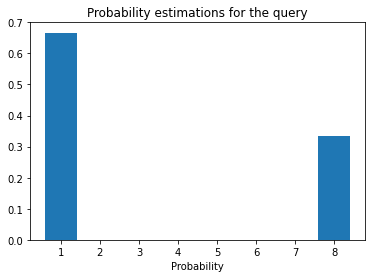

In [ ]:
#plt.scatter(learner.estimator.classes_, prediction[0])
plt.bar(learner.estimator.classes_, prediction[0])
plt.xlabel("Digit")
plt.xlabel("Probability")
plt.title("Probability estimations for the query")
plt.show()

##Toy example: The query

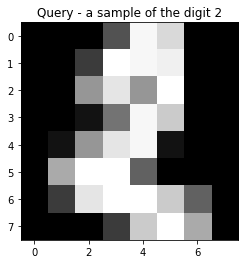

In [ ]:
temp_sample_index = 0
temp_y = y_pool[temp_sample_index]
plt.imshow(X_pool[temp_sample_index].reshape(8,8), cmap="Greys_r")
plt.title("Query - a sample of the digit "+str(temp_y))
plt.show()

##Toy example: A training set state

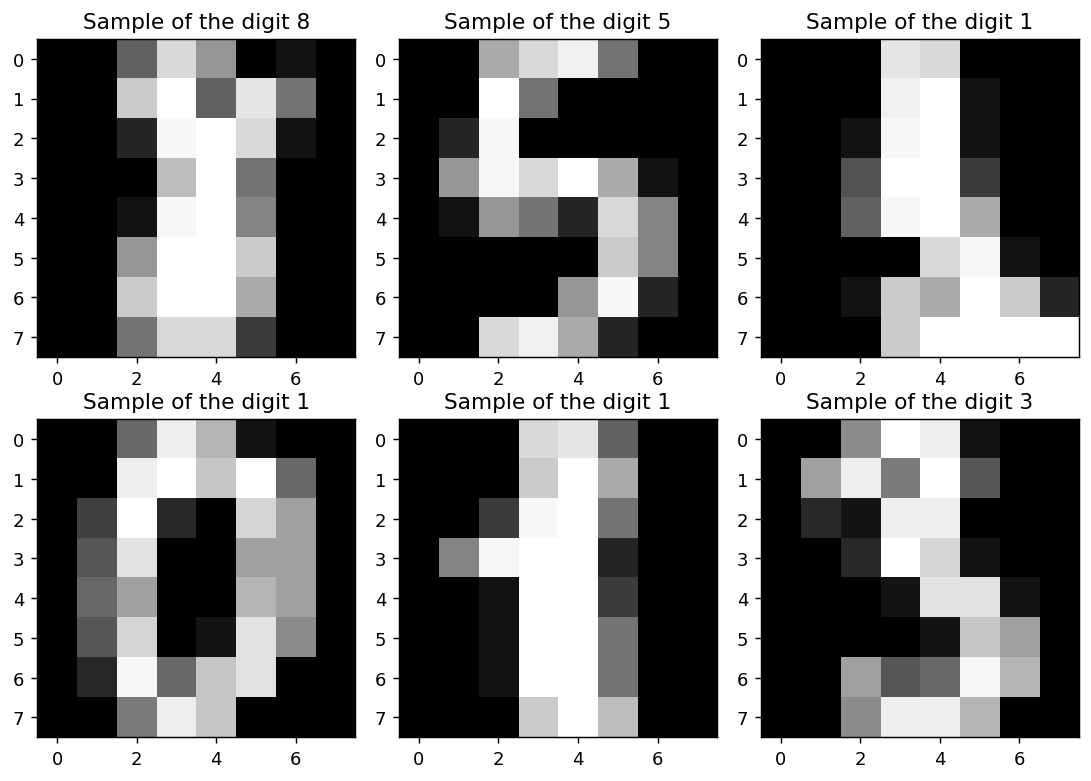

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8.5, 6), dpi=130)
temp_sample_index = 0
for i in range(2):
  for j in range(3):
    temp_y = learner.y_training[temp_sample_index]
    #print("temp_y: ", temp_y)
    axs[i,j].imshow(learner.X_training[temp_sample_index].reshape(8,8),cmap="Greys_r")
    axs[i,j].set_title("Sample of the digit "+str(temp_y))
    temp_sample_index +=1
plt.tight_layout()
plt.show()

Now we can plot our performance history. If the questions are answered correctly, the plot should have an upward trend.

After 10 queries of the active learner we should get approximately 0.06 better score than when queries were totally random (check section `Random queries score` for comparison).

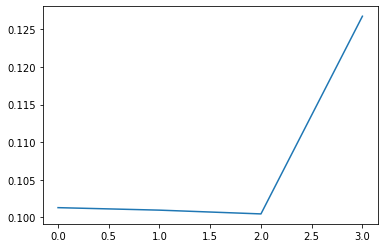

In [ ]:
import matplotlib.pyplot as plt

plt.plot(performance_history)
plt.show()

Optional: (Time-consuming!) Keras models in modAL workflows
=============================

Thanks for the scikit-learn API of Keras, you can seamlessly integrate Keras models into your modAL workflow. In this tutorial, we shall quickly introduce how to use the scikit-learn API of Keras and we are going to see how to do active learning with it. More details on the Keras scikit-learn API [can be found here](https://keras.io/scikit-learn-api/).

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/keras_integration.py)!

Keras' scikit-learn API
-----------------------

By default, a Keras model's interface differs from what is used for scikit-learn estimators. However, with the use of its scikit-learn wrapper, it is possible to adapt your model.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

# build function for the Keras' scikit-learn API
def create_keras_model():
    """
    This function compiles and returns a Keras model.
    Should be passed to KerasClassifier in the Keras scikit-learn API.
    """

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model

For our purposes, the ``classifier`` which we will initialize now acts just like any scikit-learn estimator.

In [ ]:
# create the classifier
classifier = KerasClassifier(create_keras_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Active learning with Keras
---------------------------------------

In this example, we are going to use the famous MNIST dataset, which is available as a built-in for Keras.

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 28.2 MB/s 


In [ ]:
import numpy as np
from keras.datasets import mnist

from tensorflow.keras.utils import to_categorical

# read training data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255
#y_train = keras.utils.to_categorical(y_train, 10)
y_train = to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)
y_test = to_categorical(y_test, 10)

# assemble initial data
n_initial = 1000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:5000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:5000]

11501568/11490434 [==============================] - 0s 0us/step


Active learning with data and classifier ready is as easy as always. Because training is *very* expensive in large neural networks, this time we are going to query the best 200 instances each time we measure the uncertainty of the pool.

In [ ]:
!pip install modal

In [ ]:
from modAL.models import ActiveLearner

# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

32/32 [==============================] - 3s 79ms/step - loss: 2.3228 - accuracy: 0.0990


To make sure that you train only on newly queried labels, pass ``only_new=True`` to the ``.teach()`` method of the learner.

            only_new: If True, the model is retrained using only X and y, ignoring the previously provided examples.
                Useful when working with models where the .fit() method doesn't retrain the model from scratch (e. g. in
                tensorflow or keras).

[https://github.com/modAL-python/modAL/blob/99d4947f69f0b2247f9916a6ef44463f7af06c55/modAL/models/learners.py]

In [ ]:
# the active learning loop
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100, verbose=0)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
        verbose=1
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

Query no. 1
4/4 [==============================] - 1s 59ms/step - loss: 2.3215 - accuracy: 0.0400
Query no. 2
4/4 [==============================] - 1s 64ms/step - loss: 2.3165 - accuracy: 0.0400
Query no. 3
4/4 [==============================] - 1s 67ms/step - loss: 2.3157 - accuracy: 0.0500
Query no. 4
4/4 [==============================] - 1s 64ms/step - loss: 2.3071 - accuracy: 0.1100
Query no. 5
4/4 [==============================] - 1s 59ms/step - loss: 2.2991 - accuracy: 0.1100
Query no. 6
4/4 [==============================] - 1s 62ms/step - loss: 2.3059 - accuracy: 0.1000
Query no. 7
4/4 [==============================] - 1s 60ms/step - loss: 2.3003 - accuracy: 0.1200
Query no. 8
4/4 [==============================] - 1s 64ms/step - loss: 2.3040 - accuracy: 0.1300
Query no. 9
4/4 [==============================] - 1s 60ms/step - loss: 2.2936 - accuracy: 0.1300
Query no. 10
4/4 [==============================] - 1s 59ms/step - loss: 2.3110 - accuracy: 0.0800


In [ ]:
# read training data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255
#y_train = keras.utils.to_categorical(y_train, 10)
y_train = to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)
y_test = to_categorical(y_test, 10)


In [ ]:
X_raw = X_train
y_raw = y_train

In [ ]:
shuffling_indices = np.arange(y_raw.shape[0])

In [ ]:
X_pool.shape

(4000, 28, 28, 1)

In [ ]:
y_pool.shape

(4000, 10)

Are the labels OH-encoded?

In [ ]:
np.all(y_pool.sum(axis=1) == y_pool.max(axis=1))

True

In [ ]:
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [ ]:
#n_labeled_examples

In [ ]:
#query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling, random_sampling]
query_strategies = [margin_sampling, random_sampling]
#performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
performance_histories = {"margin sampling":[], "random sampling":[]}
query_strategy_labels = ["margin sampling", "random sampling"]
number_of_tests = 2
N_QUERIES = 20


for test_number in range(number_of_tests):

  np.random.shuffle(shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []
  n_labeled_examples = X_raw.shape[0]

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    #knn = KNeighborsClassifier(n_neighbors=3)
    classifier = KerasClassifier(create_keras_model)
    #learner = ActiveLearner(estimator=classifier, X_training=X_train, y_training=y_train, query_strategy=query_strategy, verbose=True)
    learner = ActiveLearner(estimator=classifier, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      #X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      X = X_pool[query_idx]
      y = y_pool[query_idx]
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y, only_new=True)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      #X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      # remove queried instance from pool
      X_pool = np.delete(X_pool, query_idx, axis=0)
      y_pool = np.delete(y_pool, query_idx, axis=0)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


1875/1875 [==============================] - 36s 19ms/step - loss: 2.3002 - accuracy: 0.1035
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 65ms/step - loss: 2.3191 - accuracy: 0.1200
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (103, 28, 28, 1)
learner_X_training shape:  (103, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59897, 28, 28, 1)
y_pool shape:  (59897, 10)
1872/1872 [==============================] - 40s 21ms/step - loss: 2.3033 - accuracy: 0.1782
Accuracy after query 1: 0.1782
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 65ms/step - loss: 2.3210 - accuracy: 0.0900
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (203, 28, 28, 1)
learner_X_training shape:  (203, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59797, 28, 28, 1)
y_po

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


1875/1875 [==============================] - 37s 20ms/step - loss: 2.3095 - accuracy: 0.0656
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 60ms/step - loss: 2.2867 - accuracy: 0.1700
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (103, 28, 28, 1)
learner_X_training shape:  (103, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59897, 28, 28, 1)
y_pool shape:  (59897, 10)
1872/1872 [==============================] - 36s 19ms/step - loss: 2.3026 - accuracy: 0.1303
Accuracy after query 1: 0.1303
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 61ms/step - loss: 2.2965 - accuracy: 0.1400
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (203, 28, 28, 1)
learner_X_training shape:  (203, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59797, 28, 28, 1)
y_po

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


1875/1875 [==============================] - 39s 21ms/step - loss: 2.3059 - accuracy: 0.0863
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 60ms/step - loss: 2.3023 - accuracy: 0.0900
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (103, 28, 28, 1)
learner_X_training shape:  (103, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59897, 28, 28, 1)
y_pool shape:  (59897, 10)
1872/1872 [==============================] - 39s 21ms/step - loss: 2.2988 - accuracy: 0.1407
Accuracy after query 1: 0.1407
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 67ms/step - loss: 2.3072 - accuracy: 0.0700
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (203, 28, 28, 1)
learner_X_training shape:  (203, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59797, 28, 28, 1)
y_po

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


1875/1875 [==============================] - 37s 19ms/step - loss: 2.3023 - accuracy: 0.1093
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 60ms/step - loss: 2.3098 - accuracy: 0.0700
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (103, 28, 28, 1)
learner_X_training shape:  (103, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59897, 28, 28, 1)
y_pool shape:  (59897, 10)
1872/1872 [==============================] - 36s 19ms/step - loss: 2.3032 - accuracy: 0.0771
Accuracy after query 1: 0.0771
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 60ms/step - loss: 2.2929 - accuracy: 0.1000
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (203, 28, 28, 1)
learner_X_training shape:  (203, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59797, 28, 28, 1)
y_po

In [ ]:
query_strategy_label

'random sampling'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

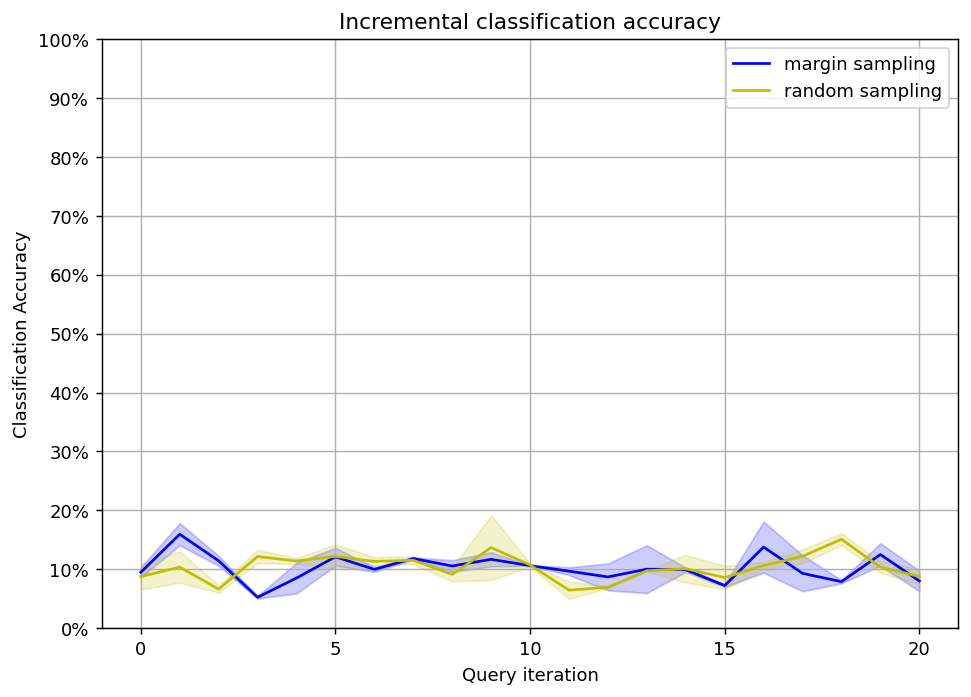

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

In [ ]:
!pip install scikeras[tensorflow]

     |████████████████████████████████| 97 kB 6.2 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
  Attempting uninstall: markdown
    Found existing installation: Markdown 3.3.6
    Uninstalling Markdown-3.3.6:
      Successfully uninstalled Markdown-3.3.6


In [ ]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

In [ ]:
# create the classifier
classifier = KerasClassifier(create_keras_model)

Warning: The following is even more time-consuming!

In [ ]:
#query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling, random_sampling]
query_strategies = [margin_sampling, random_sampling]
#performance_histories = {"uncertainty sampling":[], "margin sampling":[], "entropy sampling":[], "random sampling":[]}
performance_histories = {"margin sampling":[], "random sampling":[]}
number_of_tests = 2
N_QUERIES = 20


for test_number in range(number_of_tests):

  np.random.shuffle(shuffling_indices)
  X_raw = X_raw[shuffling_indices]
  y_raw = y_raw[shuffling_indices]

  #performance_histories = []

  for query_strategy_idx, query_strategy in enumerate(query_strategies):

    query_strategy_label = query_strategy_labels[query_strategy_idx]

    #training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)

    #knn = KNeighborsClassifier(n_neighbors=3)
    classifier = KerasClassifier(create_keras_model)
    #learner = ActiveLearner(estimator=classifier, X_training=X_train, y_training=y_train, query_strategy=query_strategy, verbose=True)
    learner = ActiveLearner(estimator=classifier, X_training=X_train, y_training=y_train, query_strategy=query_strategy)

    #N_QUERIES = 50
    unqueried_score = learner.score(X_pool, y_pool)
    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(N_QUERIES):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      #X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      X = X_pool[query_idx]
      y = y_pool[query_idx]
      print("X type: ", type(X))
      print("X shape: ", X.shape)
      print("y shape: ", y.shape)
      learner.teach(X=X, y=y, only_new=True)

      learner_X_training = learner.X_training
      print("learner_X_training type: ", type(learner_X_training))
      print("learner_X_training shape: ", learner_X_training.shape)
      print("learner_X_training shape: ", learner_X_training.shape)

      # Remove the queried instance from the unlabeled pool.
      #X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
      # remove queried instance from pool
      X_pool = np.delete(X_pool, query_idx, axis=0)
      y_pool = np.delete(y_pool, query_idx, axis=0)
      print("X_pool type: ", type(X_pool))
      print("X_pool shape: ", X_pool.shape)
      print("y_pool shape: ", y_pool.shape)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_pool, y_pool)
      print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    performance_histories[query_strategy_label].append(performance_history)

1875/1875 [==============================] - 35s 19ms/step
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 65ms/step - loss: 2.3151 - accuracy: 0.0800
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (103, 28, 28, 1)
learner_X_training shape:  (103, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59897, 28, 28, 1)
y_pool shape:  (59897, 10)
1872/1872 [==============================] - 34s 18ms/step
Accuracy after query 1: 0.0621
1872/1872 [==============================] - 34s 18ms/step
X type:  <class 'numpy.ndarray'>
X shape:  (100, 28, 28, 1)
y shape:  (100, 10)
4/4 [==============================] - 1s 63ms/step - loss: 2.2699 - accuracy: 0.2000
learner_X_training type:  <class 'numpy.ndarray'>
learner_X_training shape:  (203, 28, 28, 1)
learner_X_training shape:  (203, 28, 28, 1)
X_pool type:  <class 'numpy.ndarray'>
X_pool shape:  (59797, 28, 28, 1)
y_pool shape:

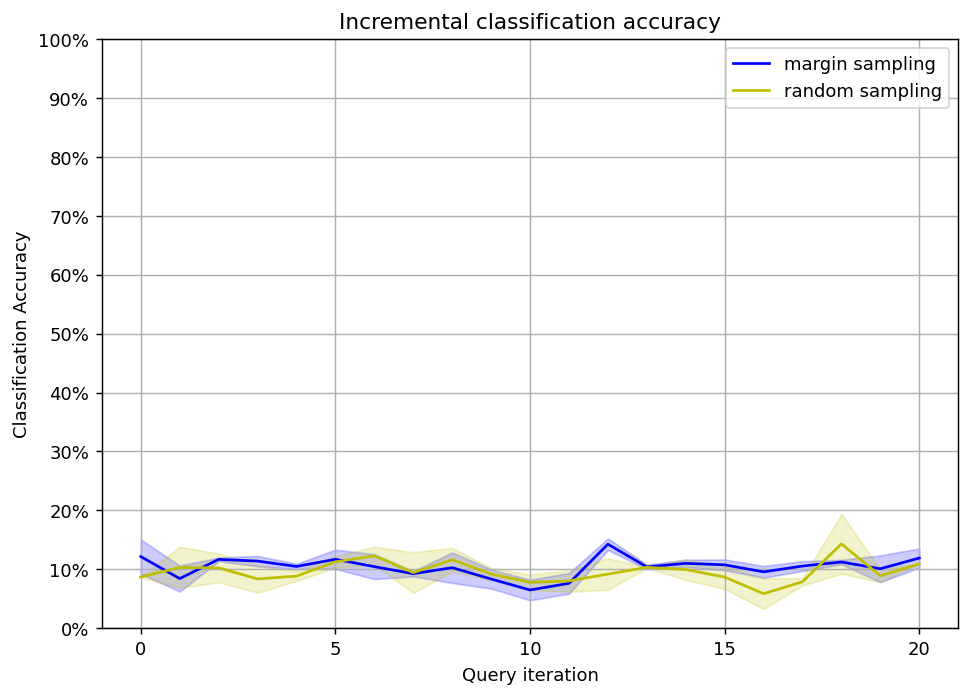

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
temp_color_letters = ["b", "y", "g", "r"]


for query_strategy_idx, query_strategy in enumerate(query_strategies):
  query_strategy_label = query_strategy_labels[query_strategy_idx]
  performance_history = performance_histories[query_strategy_label]
  #ax.plot(performance_history, label=query_strategy_label)
  #ax.scatter(range(len(performance_history)), performance_history, s=13)
  temp_mean = np.mean(np.array(performance_history), axis=0)
  temp_std = np.std(np.array(performance_history), axis=0)
  temp_color_letter = temp_color_letters[query_strategy_idx]
  x = np.arange(len(temp_mean))
  plt.plot(x, temp_mean, temp_color_letter+"-", label=query_strategy_label)
  plt.fill_between(x, temp_mean - temp_std, temp_mean + temp_std, color=temp_color_letter, alpha=0.2)


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

#Some well-known multi-class dataset potentially usefull to demonstrate the  advantage of model-based querry strategies over random sampling being more evident in multi-class scenarios

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_data = fetch_20newsgroups()

In [ ]:
print(newsgroups_data["DESCR"])

In [ ]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3
dlib @ file:///dlib-19.18.0-cp37-cp37m-linux_x86_64.whl
dm-tree==0.1.6
docopt==0.6.2
docutils==0.17.1
dopamine-rl==1.0.5
earthengine-api==0.1.299
easydict==1.9
ecos==2.0.10
editdistance==0.5.3
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
entrypoints==0.4
ephem==4.1.3
et-xmlfile==1.1.0
fa2==0.3.5
fastai==1.0.61
fastdtw==0.3.4
fastprogress==1.0.2
fastrlock==0.8
fbprophet==0.7.1
feather-format==0.4.1
filelock==3.6.0
firebase-admin==4.4.0
fix-yahoo-finance==0.0.22
Flask==1.1.4
flatbuffers==2.0
folium==0.8.3
future==0.16.0
gast==0.5.3
GDAL==2.2.2
gdown==4.2.1
gensim==3.6.0
geographiclib==1.52
geopy==1.17.0
gin-config==0.5.0
glob2==0.7
google==2.0.3
google-api-core==1.26.3
google-api-python-client==1.12.10
google-auth==1.35.0
google-auth-httplib2==0.0.4
google-auth-oauthlib==0.4.6
google-cloud-bigquery==1.21.0
google-cloud-bigquery-storage==1.1.0
google-cloud-core==1.0.3
google-cloud-datastore==1.8.0
google-cloud-firestore==1.7.0
google-cloud-language==1.2.0
google-cloud-storage==1.18.1
google-cloud-translate==1.5.0
google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz
google-pasta==0.2.0
google-resumable-media==0.4.1
googleapis-common-protos==1.54.0
googledrivedownloader==0.4
graphviz==0.10.1
greenlet==1.1.2
grpcio==1.43.0
gspread==3.4.2
gspread-dataframe==3.0.8
gspread-formatting==1.0.6
gym==0.17.3
h5py==3.1.0
HeapDict==1.0.1
hijri-converter==2.2.3
holidays==0.10.5.2
holoviews==1.14.8
html5lib==1.0.1
httpimport==0.5.18
httplib2==0.17.4
httplib2shim==0.0.3
humanize==0.5.1
hyperopt==0.1.2
ideep4py==2.0.0.post3
idna==2.10
imageio==2.4.1
imagesize==1.3.0
imbalanced-learn==0.8.1
imblearn==0.0
imgaug==0.2.9
importlib-metadata==3.10.1
importlib-resources==5.4.0
imutils==0.5.4
inflect==2.1.0
iniconfig==1.1.1
intel-openmp==2022.0.2
intervaltree==2.1.0
ipykernel==4.10.1
ipython==5.5.0
ipython-genutils==0.2.0
ipython-sql==0.3.9
ipywidgets==7.6.5
itsdangerous==1.1.0
jax==0.2.25
jaxlib @ https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.71+cuda111-cp37-none-manylinux2010_x86_64.whl
jedi==0.18.1
jieba==0.42.1
Jinja2==2.11.3
joblib==1.1.0
jpeg4py==0.1.4
jsonschema==4.3.3
jupyter==1.0.0
jupyter-client==5.3.5
jupyter-console==5.2.0
jupyter-core==4.9.2
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kaggle==1.5.12
kapre==0.3.7
keras==2.8.0
Keras-Preprocessing==1.1.2
keras-vis==0.4.1
kiwisolver==1.3.2
korean-lunar-calendar==0.2.1
libclang==13.0.0
librosa==0.8.1
lightgbm==2.2.3
llvmlite==0.34.0
lmdb==0.99
LunarCalendar==0.0.9
lxml==4.2.6
Markdown==3.3.4
MarkupSafe==2.0.1
matplotlib==3.2.2
matplotlib-inline==0.1.3
matplotlib-venn==0.11.6
missingno==0.5.0
mistune==0.8.4
mizani==0.6.0
mkl==2019.0
mlxtend==0.14.0
modAL==0.4.1
more-itertools==8.12.0
moviepy==0.2.3.5
mpmath==1.2.1
msgpack==1.0.3
multiprocess==0.70.12.2
multitasking==0.0.10
murmurhash==1.0.6
music21==5.5.0
natsort==5.5.0
nbclient==0.5.11
nbconvert==5.6.1
nbformat==5.1.3
nest-asyncio==1.5.4
netCDF4==1.5.8
networkx==2.6.3
nibabel==3.0.2
nltk==3.2.5
notebook==5.3.1
numba==0.51.2
numexpr==2.8.1
numpy==1.21.5
nvidia-ml-py3==7.352.0
oauth2client==4.1.3
oauthlib==3.2.0
okgrade==0.4.3
opencv-contrib-python==4.1.2.30
opencv-python==4.1.2.30
openpyxl==3.0.9
opt-einsum==3.3.0
osqp==0.6.2.post0
packaging==21.3
palettable==3.3.0
pandas==1.3.5
pandas-datareader==0.9.0
pandas-gbq==0.13.3
pandas-profiling==1.4.1
pandocfilters==1.5.0
panel==0.12.1
param==1.12.0
parso==0.8.3
pathlib==1.0.1
patsy==0.5.2
pep517==0.12.0
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.1.2
pip-tools==6.2.0
plac==1.1.3
plotly==5.5.0
plotnine==0.6.0
pluggy==0.7.1
pooch==1.6.0
portpicker==1.3.9
prefetch-generator==1.0.1
preshed==3.0.6
prettytable==3.1.1
progressbar2==3.38.0
prometheus-client==0.13.1
promise==2.3
prompt-toolkit==1.0.18
protobuf==3.17.3
psutil==5.4.8
psycopg2==2.7.6.1
ptyprocess==0.7.0
py==1.11.0
pyarrow==6.0.1
pyasn1==0.4.8
pyasn1-modules==0.2.8
pycocotools==2.0.4
pycparser==2.21
pyct==0.4.8
pydata-google-auth==1.3.0
pydot==1.3.0
pydot-ng==2.0.0
pydotplus==2.0.2
PyDrive==1.3.1
pyemd==0.5.1
pyerfa==2.0.0.1
pyglet==1.5.0
Pygments==2.6.1
pygobject==3.26.1
pymc3==3.11.4
PyMeeus==0.5.11
pymongo==4.0.1
pymystem3==0.2.0
PyOpenGL==3.1.5
pyparsing==3.0.7
pyrsistent==0.18.1
pysndfile==1.3.8
PySocks==1.7.1
pystan==2.19.1.1
pytest==3.6.4
python-apt==0.0.0
python-chess==0.23.11
python-dateutil==2.8.2
python-louvain==0.16
python-slugify==6.0.1
python-utils==3.1.0
pytz==2018.9
pyviz-comms==2.1.0
PyWavelets==1.2.0
PyYAML==3.13
pyzmq==22.3.0
qdldl==0.1.5.post0
qtconsole==5.2.2
QtPy==2.0.1
regex==2019.12.20
requests==2.23.0
requests-oauthlib==1.3.1
resampy==0.2.2
rpy2==3.4.5
rsa==4.8
scikeras==0.6.1
scikit-image==0.18.3
scikit-learn==1.0.2
scipy==1.4.1
screen-resolution-extra==0.0.0
scs==3.1.0
seaborn==0.11.2
semver==2.13.0
Send2Trash==1.8.0
setuptools-git==1.2
Shapely==1.8.1
simplegeneric==0.8.1
six==1.15.0
sklearn==0.0
sklearn-pandas==1.8.0
smart-open==5.2.1
snowballstemmer==2.2.0
sortedcontainers==2.4.0
SoundFile==0.10.3.post1
spacy==2.2.4
Sphinx==1.8.6
sphinxcontrib-serializinghtml==1.1.5
sphinxcontrib-websupport==1.2.4
SQLAlchemy==1.4.31
sqlparse==0.4.2
srsly==1.0.5
statsmodels==0.10.2
sympy==1.7.1
tables==3.7.0
tabulate==0.8.9
tblib==1.7.0
tenacity==8.0.1
tensorboard==2.8.0
tensorboard-data-server==0.6.1
tensorboard-plugin-wit==1.8.1
tensorflow @ file:///tensorflow-2.8.0-cp37-cp37m-linux_x86_64.whl
tensorflow-datasets==4.0.1
tensorflow-estimator==2.8.0
tensorflow-gcs-config==2.8.0
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.24.0
tensorflow-metadata==1.6.0
tensorflow-probability==0.16.0
termcolor==1.1.0
terminado==0.13.1
testpath==0.5.0
text-unidecode==1.3
textblob==0.15.3
tf-estimator-nightly==2.8.0.dev2021122109
Theano-PyMC==1.1.2
thinc==7.4.0
threadpoolctl==3.1.0
tifffile==2021.11.2
tomli==2.0.1
toolz==0.11.2
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl
tornado==5.1.1
tqdm==4.62.3
traitlets==5.1.1
tweepy==3.10.0
typeguard==2.7.1
typing-extensions==3.10.0.2
tzlocal==1.5.1
uritemplate==3.0.1
urllib3==1.24.3
vega-datasets==0.9.0
wasabi==0.9.0
wcwidth==0.2.5
webencodings==0.5.1
Werkzeug==1.0.1
widgetsnbextension==3.5.2
wordcloud==1.5.0
wrapt==1.13.3
xarray==0.18.2
xgboost==0.90
xkit==0.0.0
xlrd==1.1.0
xlwt==1.3.0
zict==2.0.0
zipp==3.7.0